# **Unraveling the Dynamics of Airfare Price Predictions**

Dennis Myasnyankin, Vannessa Salazar, and Christine Vu

Shiley-Marcos School of Engineering, University of San Diego

ADS 599: Capstone Project

Professor Ebrahim Tarshizi

December 11, 2023

***

## **Data Importing**

### **Import Libraries**

In [1]:
import pandas as pd
import zipfile
import io
import os
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas import json_normalize
from datetime import datetime
from io import BytesIO
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

### **Data Acquisition and Aggregation**

In [2]:
github_repo_url = 'https://github.com/VSbr22/Capstone/raw/main/data/jsons.zip'

# Fetch the zip file from the GitHub repository
response = requests.get(github_repo_url)
zip_file = BytesIO(response.content)

In [3]:
# Unzip the folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('your_unzipped_folder')

In [4]:
# List all JSON files in the 'jsons' subfolder
json_subfolder = os.path.join('your_unzipped_folder', 'jsons')
json_files = [file for file in os.listdir(json_subfolder) if file.endswith('.json')]

# Initialize an empty list for extracted data
out = []

# Iterate over each JSON file
for file_name in json_files:
    # Load JSON data
    with open(os.path.join(json_subfolder, file_name), 'r') as file:
        data = json.load(file)

    # Christines code for processing
    schedule_descs = data["groupedItineraryResponse"]["scheduleDescs"]
    leg_descs = data["groupedItineraryResponse"]["legDescs"]
    itinerary_groups = data["groupedItineraryResponse"]["itineraryGroups"]

    # Iterate over itinerary groups
    for group in itinerary_groups:
        itineraries = group.get("itineraries", [])
        departure_date = group["groupDescription"]["legDescriptions"][0]["departureDate"]
        departure_city = group["groupDescription"]["legDescriptions"][0]["departureLocation"]
        arrival_date = group["groupDescription"]["legDescriptions"][0].get("arrivalDate", departure_date)
        arrival_location = group["groupDescription"]["legDescriptions"][0]["arrivalLocation"]

        # Calculate "Days Until Departure" based on current date and departure date
        current_date = datetime.now()
        departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
        days_until_departure = (departure_date - current_date).days

        # Iterate over itineraries in the group
        for itinerary in itineraries:
            legs = itinerary.get("legs", [])
            for leg in legs:
                schedules = leg_descs[leg.get('ref') - 1].get("schedules", [])
                for schedule in schedules:
                    schedule_data = schedule_descs[schedule.get('ref') - 1]

                    departure_time = schedule_data["departure"]["time"].split("+")[0]
                    arrival_time = schedule_data["arrival"]["time"].split("+")[0]
                    flight_duration = schedule_data["elapsedTime"]
                    operating_carrier = schedule_data["carrier"]["operating"]
                    aircraft_type = schedule_data["carrier"]["equipment"]["code"]
                    cabin_class = itinerary["pricingInformation"][0]["fare"]["passengerInfoList"][0]["passengerInfo"]["fareComponents"][0]["segments"][0]["segment"]["cabinCode"]
                    fare_class = itinerary["pricingInformation"][0]["fare"]["passengerInfoList"][0]["passengerInfo"]["fareComponents"][0]["segments"][0]["segment"]["bookingCode"]
                    price = itinerary["pricingInformation"][0]["fare"]["totalFare"]["totalPrice"]

                    # Add to output
                    out.append([
                        departure_city, departure_date, departure_time,
                        arrival_location, arrival_date, arrival_time,
                        flight_duration, operating_carrier, aircraft_type,
                        cabin_class, fare_class, price, days_until_departure
                    ])

# Creating a DataFrame
columns = [
    "Departure City", "Departure Date", "Departure Time",
    "Arrival Location", "Arrival Date", "Arrival Time",
    "Flight Duration", "Operating Carrier", "Aircraft Type",
    "Cabin Class", "Fare Class", "Price", "Days Until Departure"
]

df = pd.DataFrame(out, columns= columns)
df

,Departure City,Departure Date,Departure Time,Arrival Location,Arrival Date,Arrival Time,Flight Duration,Operating Carrier,Aircraft Type,Cabin Class,Fare Class,Price,Days Until Departure
0,BKK,2023-12-15,09:05:00,CNX,2023-12-15,10:25:00,80,TG,32A,Y,T,74.8,3
1,BKK,2023-12-15,08:00:00,CNX,2023-12-15,09:20:00,80,PG,320,Y,L,94.8,3
2,BKK,2023-12-15,12:25:00,CNX,2023-12-15,13:45:00,80,PG,320,Y,L,94.8,3
3,BKK,2023-12-15,17:35:00,CNX,2023-12-15,18:55:00,80,PG,319,Y,T,105.8,3
4,BKK,2023-12-15,10:00:00,CNX,2023-12-15,11:20:00,80,PG,319,Y,T,105.8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,ZRH,2023-11-22,19:55:00,FRA,2023-11-22,20:55:00,60,LH,319,Y,U,894.6,-20
8191,ZRH,2023-11-22,09:00:00,FRA,2023-11-22,10:00:00,60,LH,32A,Y,M,1061.6,-20
8192,ZRH,2023-11-22,07:00:00,FRA,2023-11-22,08:05:00,65,LX,223,Y,M,1061.6,-20
8193,ZRH,2023-11-22,07:00:00,FRA,2023-11-22,08:05:00,65,LX,223,Y,M,1061.6,-20


***

## **Exploratory Data Analysis**

In [5]:
# Check data type of features
df.dtypes

Departure City                  object
Departure Date          datetime64[ns]
Departure Time                  object
Arrival Location                object
Arrival Date                    object
Arrival Time                    object
Flight Duration                  int64
Operating Carrier               object
Aircraft Type                   object
Cabin Class                     object
Fare Class                      object
Price                          float64
Days Until Departure             int64
dtype: object

In [6]:
# Key statistics of studied variables
df.describe()

,Flight Duration,Price,Days Until Departure
count,8195.000000,8195.000000,8195.000000
mean,149.657474,397.953963,-14.194875
std,108.207384,520.505156,12.903113
min,45.000000,30.300000,-27.000000
25%,80.000000,165.950000,-27.000000
50%,110.000000,253.980000,-20.000000
75%,165.000000,413.500000,3.000000
max,545.000000,9920.800000,3.000000


In [7]:
print("DataFrame Shape:", df.shape)

DataFrame Shape: (8195, 13)


### **Itinerary Counts by Departure Date**

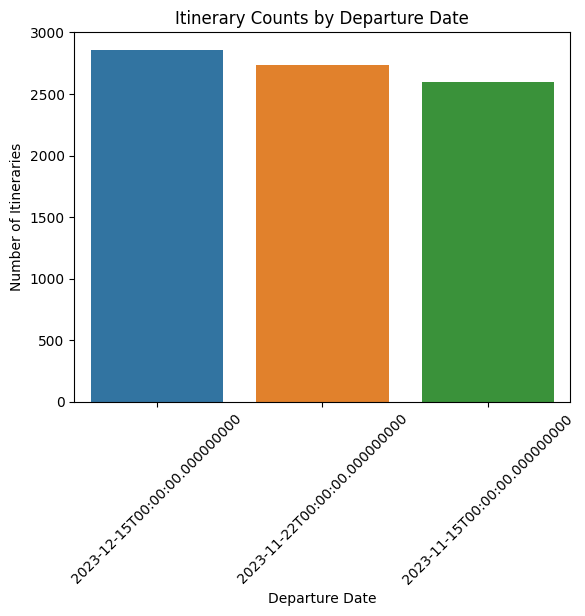

In [8]:
sns.countplot(x = 'Departure Date', data = df)
plt.title('Itinerary Counts by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Number of Itineraries')
plt.xticks(rotation = 45)
plt.show()

### **Price vs. Days Until Departure**

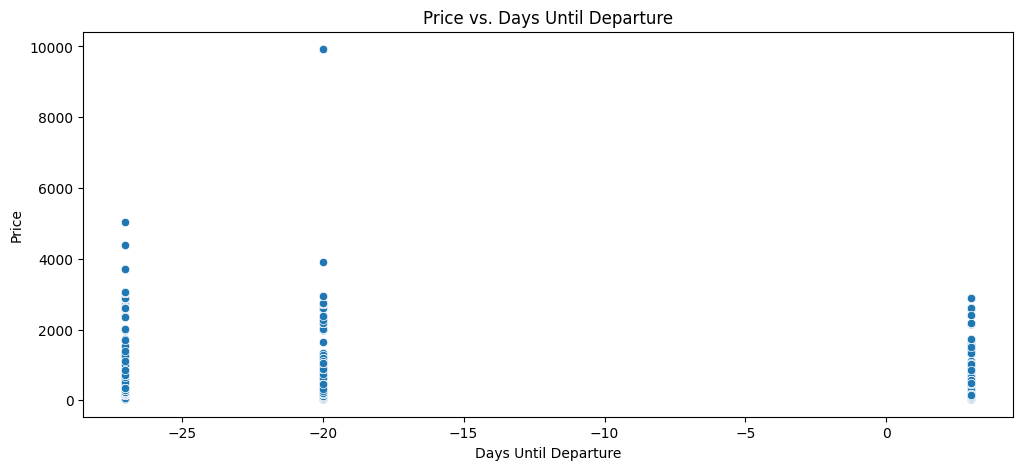

In [9]:
plt.figure(figsize = (12, 5))
sns.scatterplot(x = 'Days Until Departure', y = 'Price', data = df)
plt.title('Price vs. Days Until Departure')
plt.xlabel('Days Until Departure')
plt.ylabel('Price')
plt.show()

### **Average Price by Departure Date**

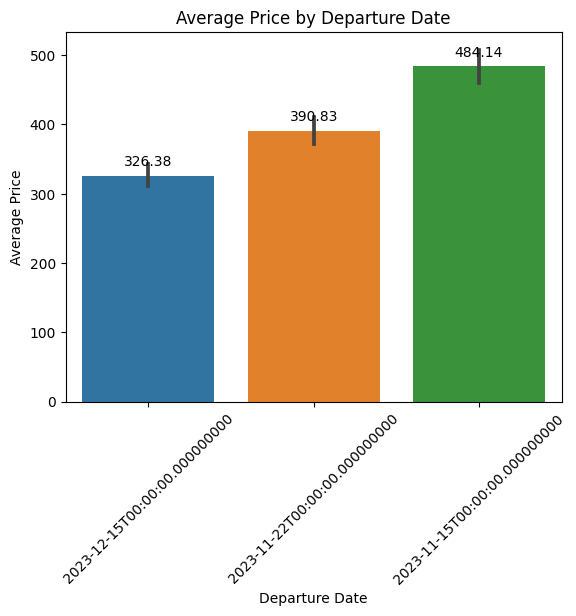

In [10]:
# Your existing code for plotting
barplot = sns.barplot(x = 'Departure Date', y = 'Price', data = df)
plt.title('Average Price by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Average Price')
plt.xticks(rotation = 45)

# Adding labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

plt.show()

### **Distribution of Categorical Features**

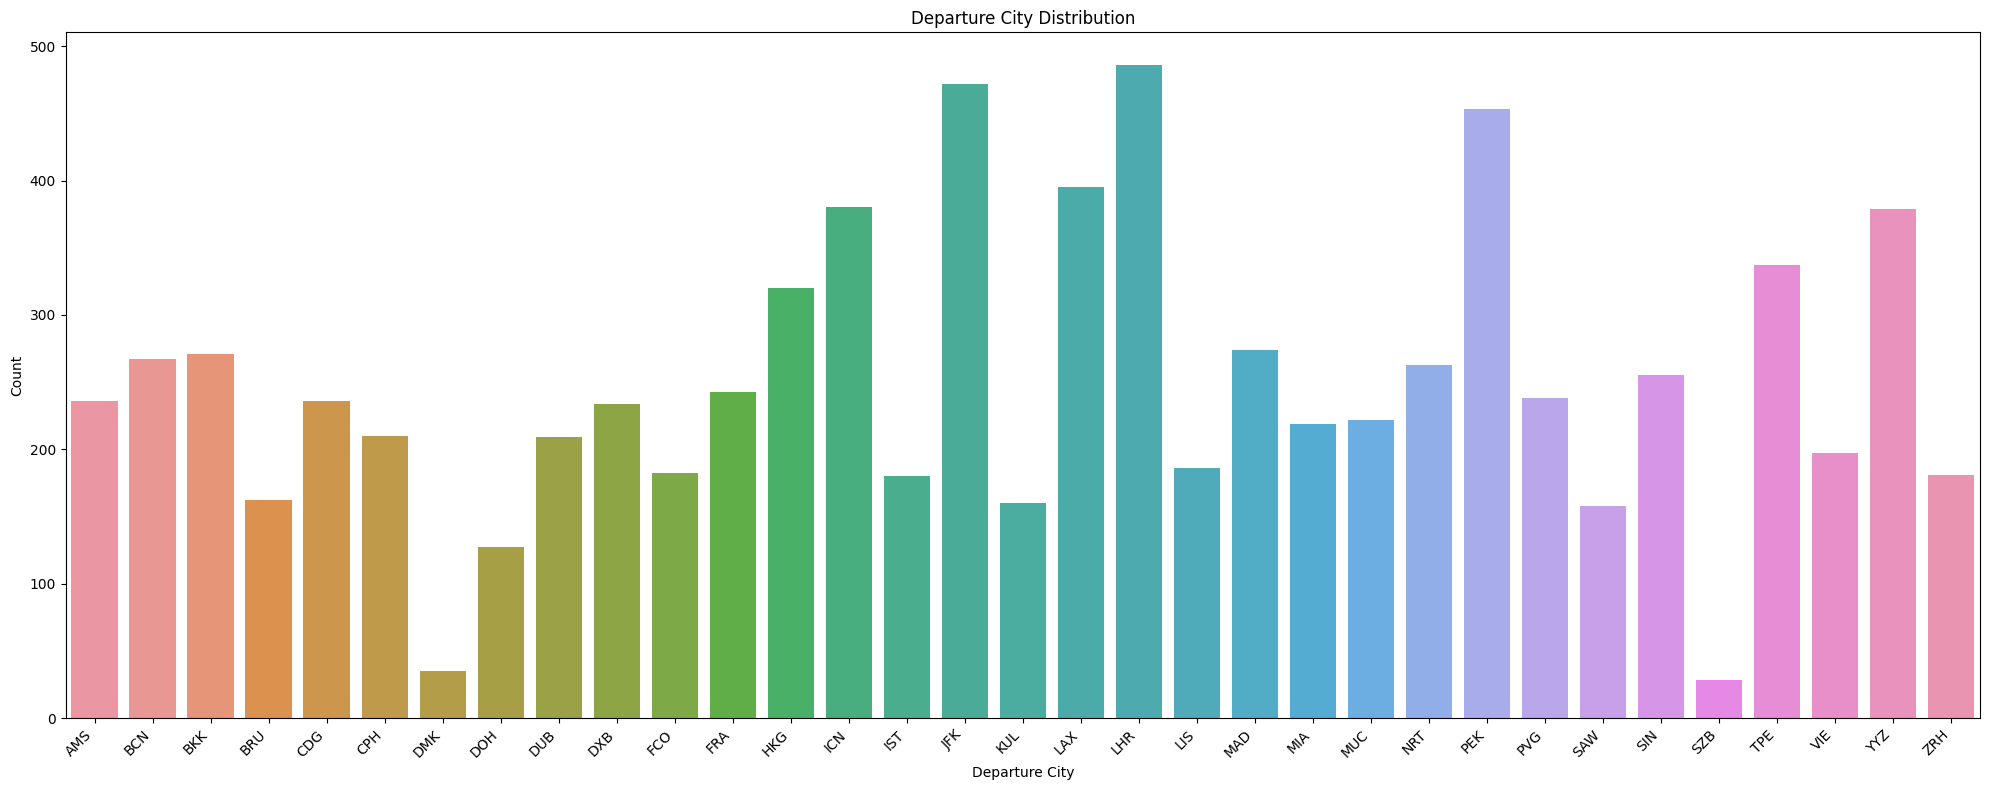

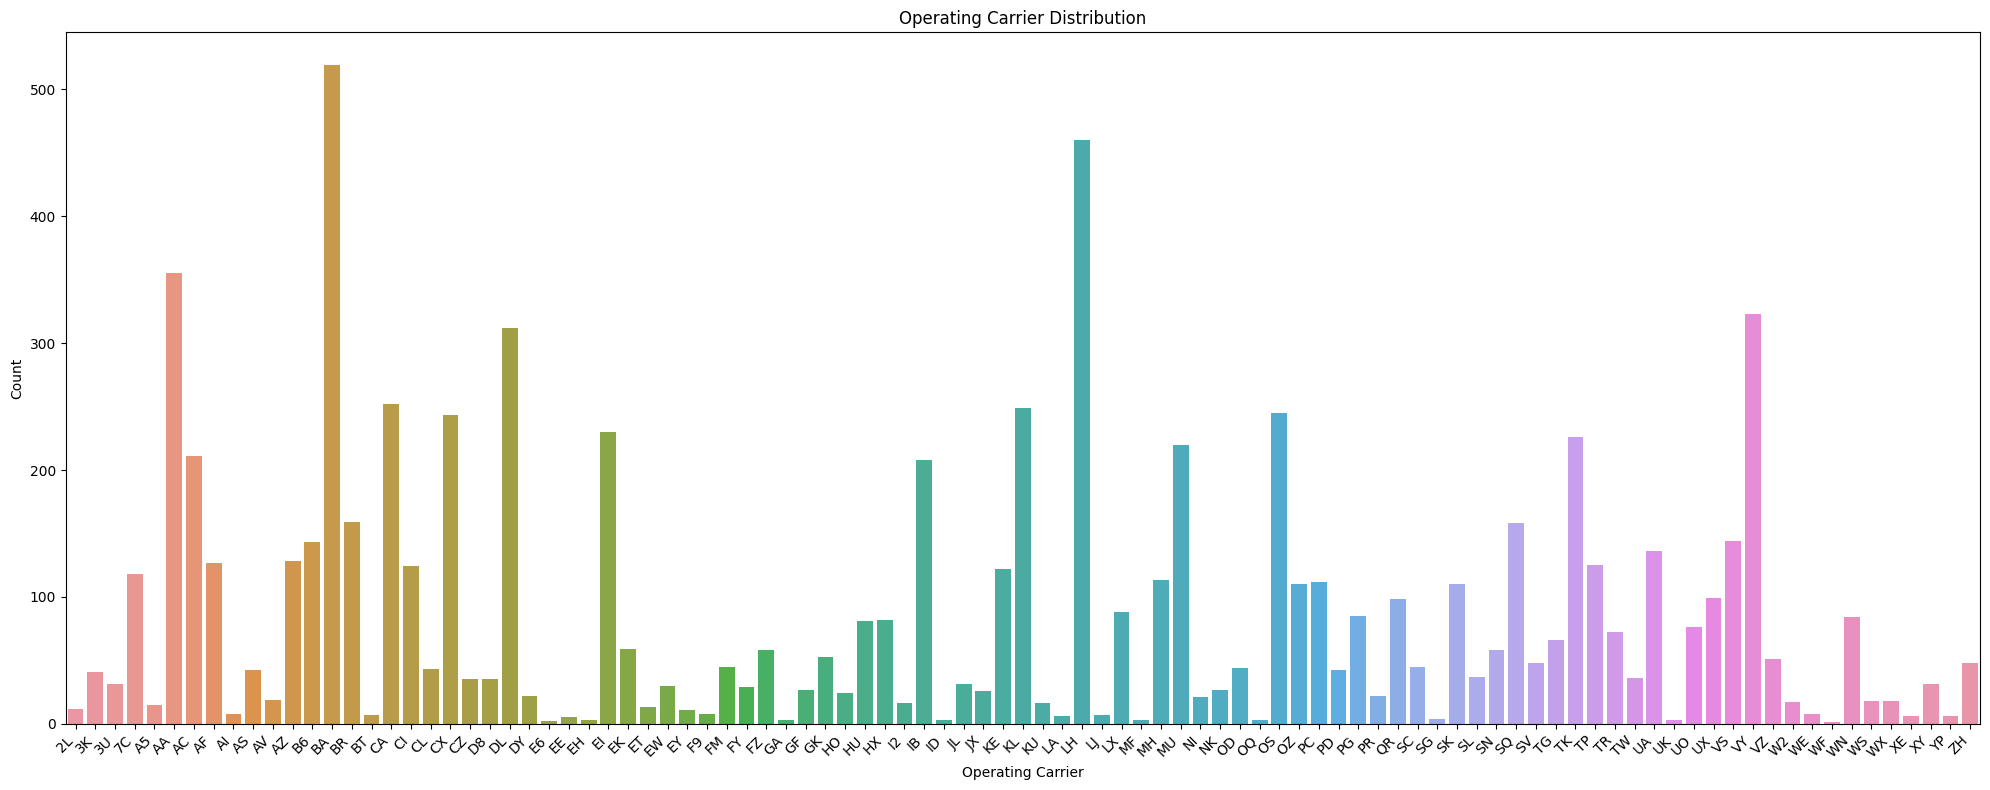

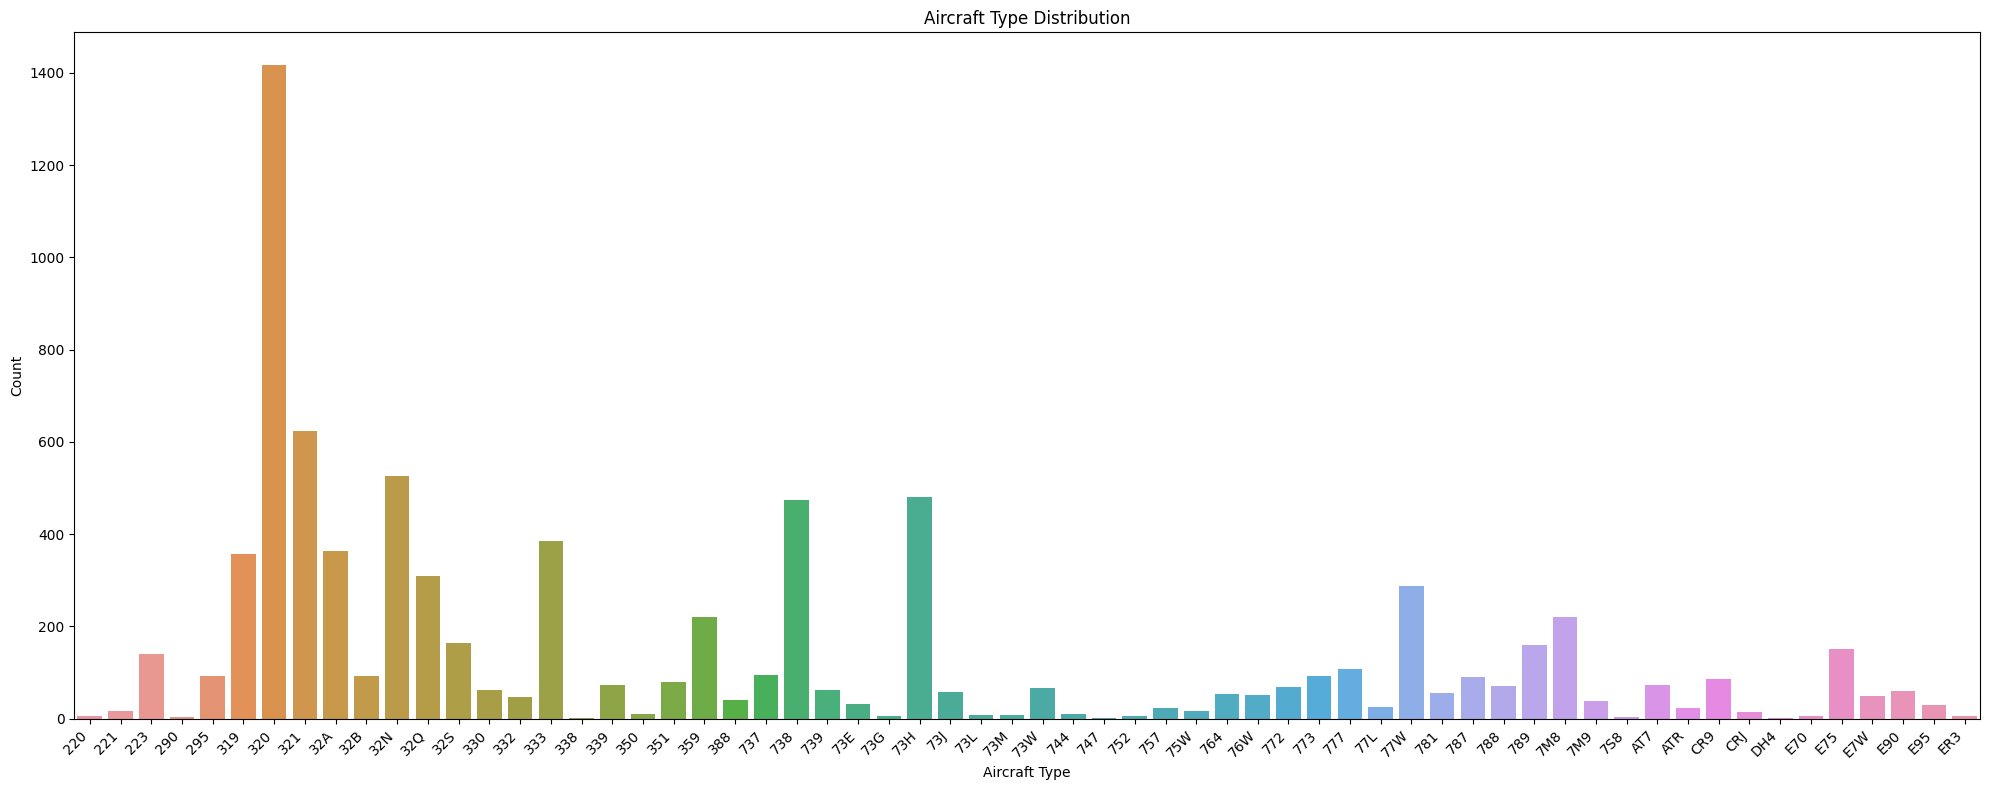

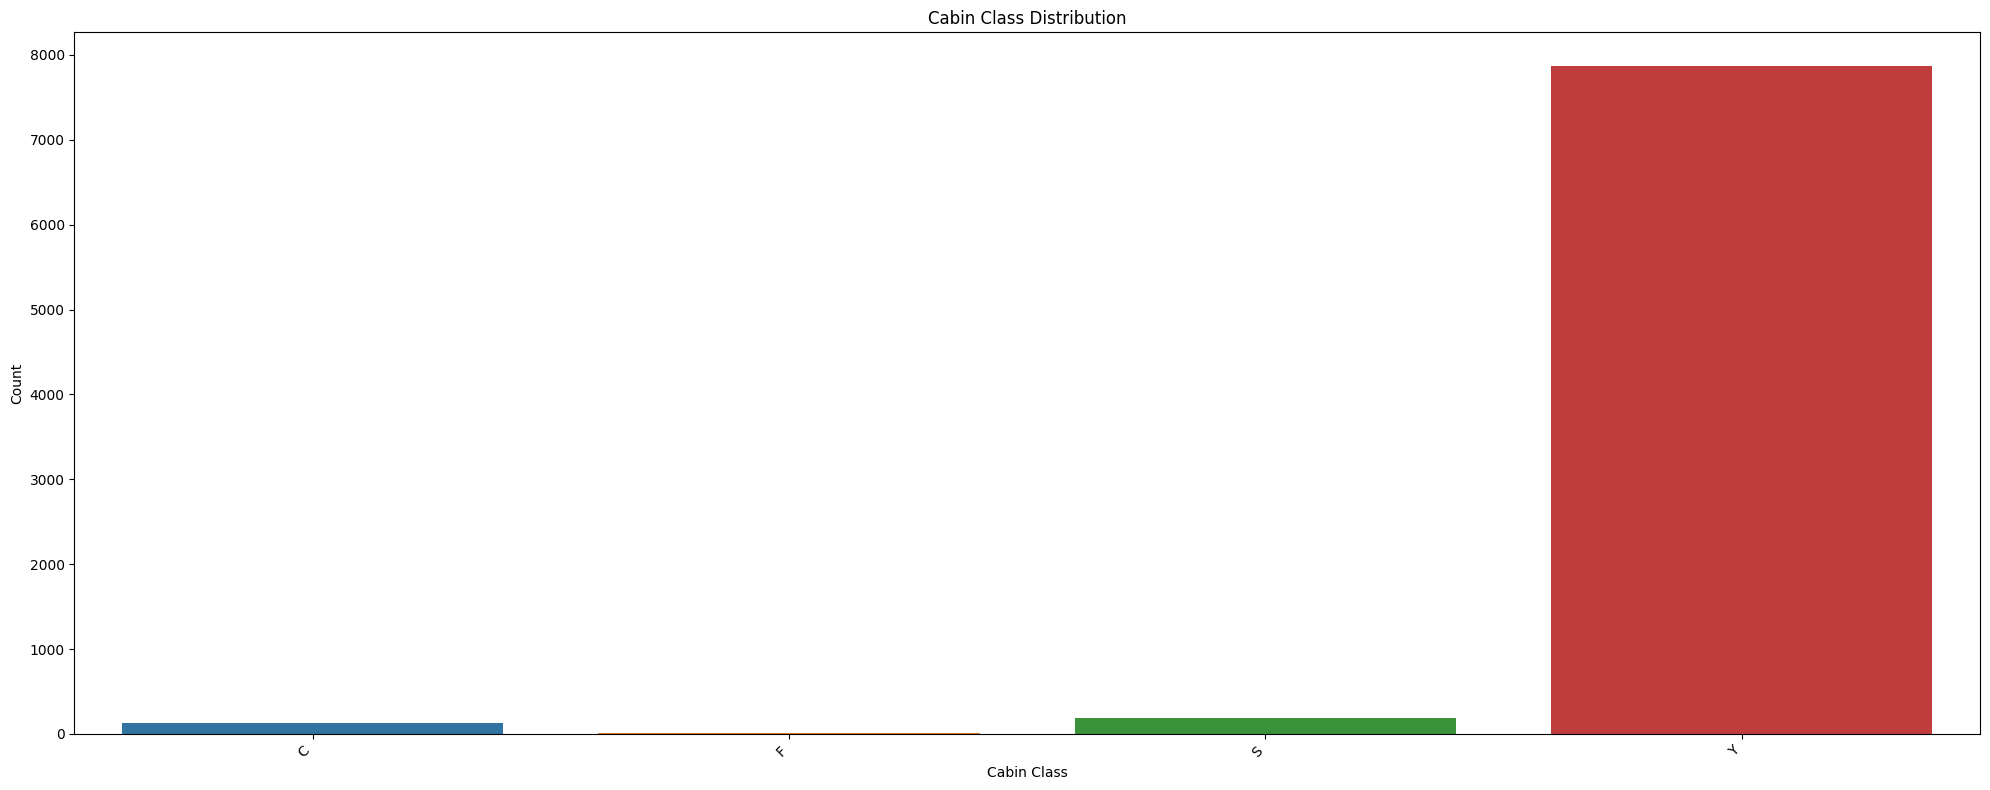

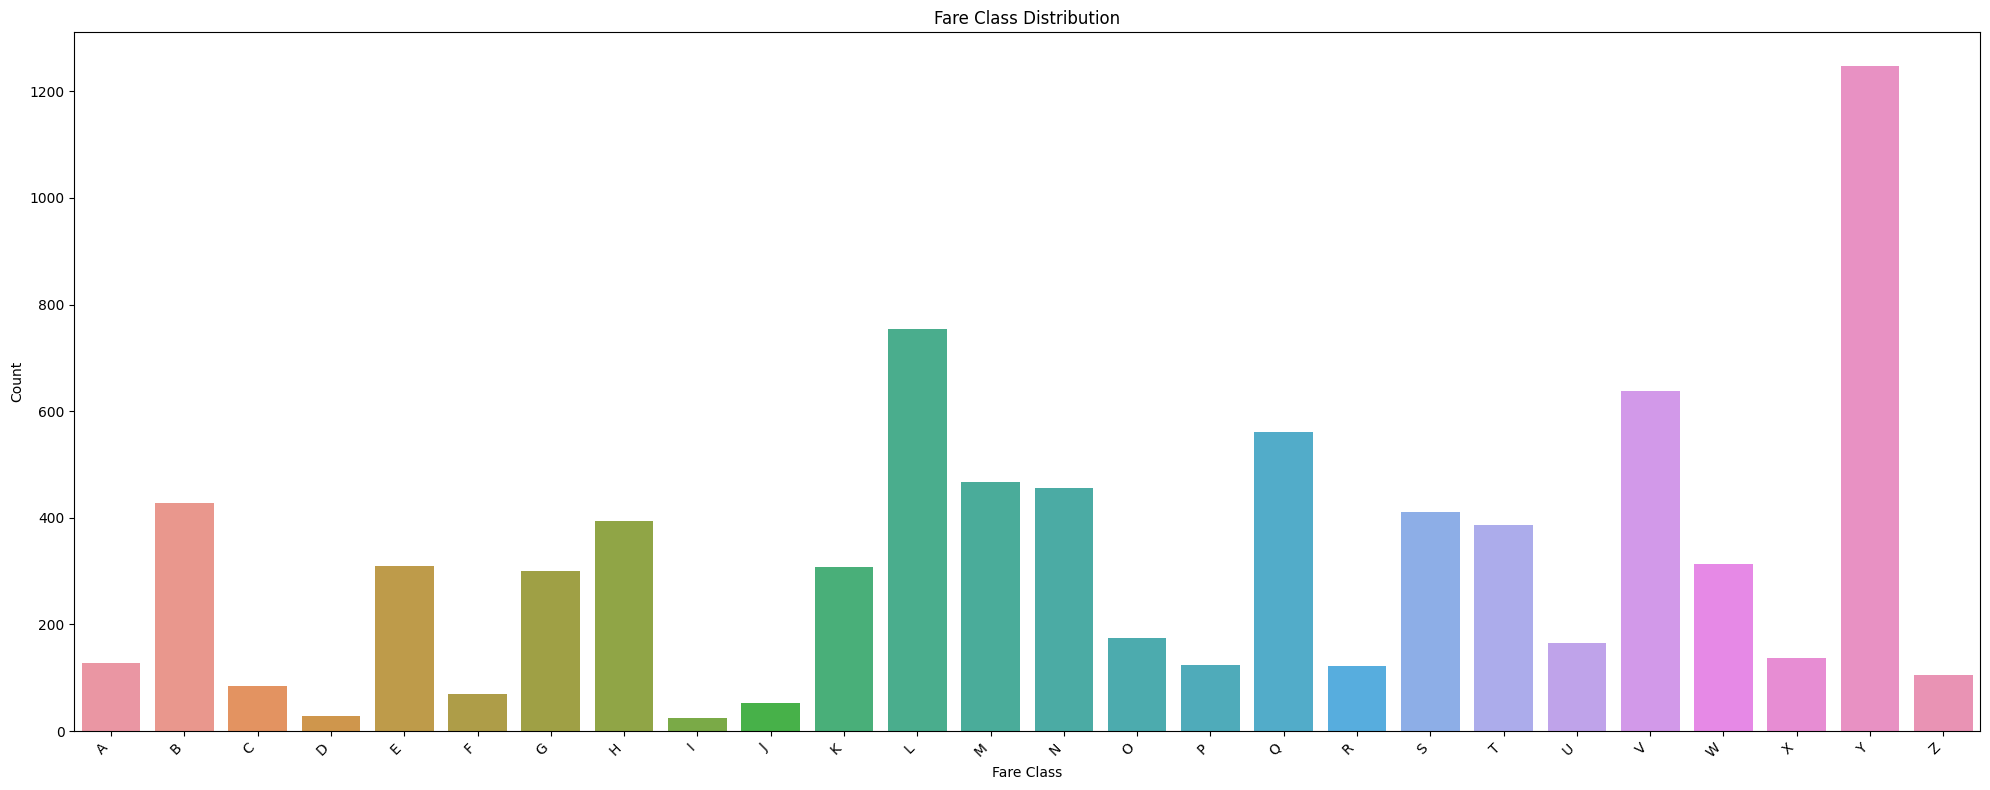

In [11]:
categorical_columns = ['Departure City', 'Operating Carrier', 'Aircraft Type', 'Cabin Class', 'Fare Class']

for column in categorical_columns:
    plt.figure(figsize = (20, 8))
    sns.countplot(x = column, data=df, order = sorted(df[column].unique()))
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.show()

### **Distribution of Numerical Features**

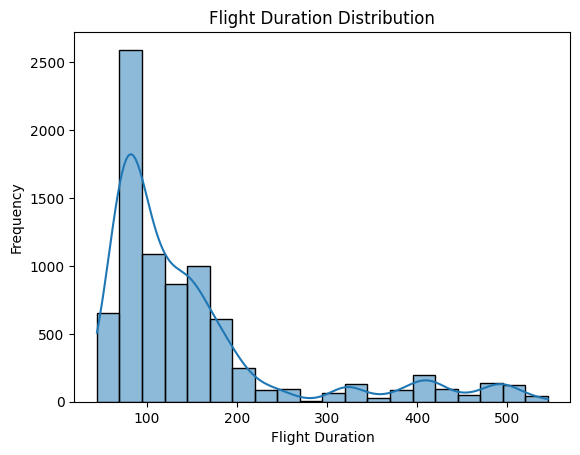

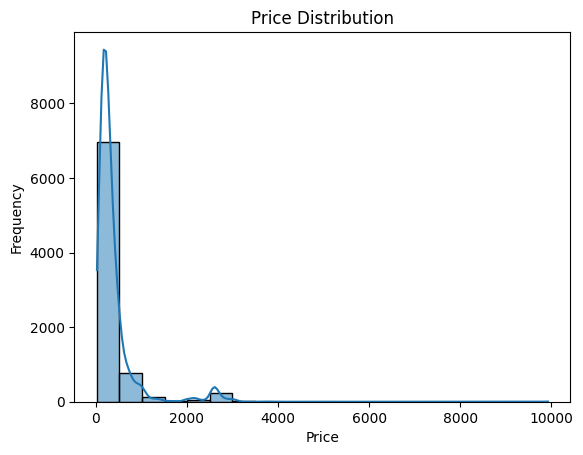

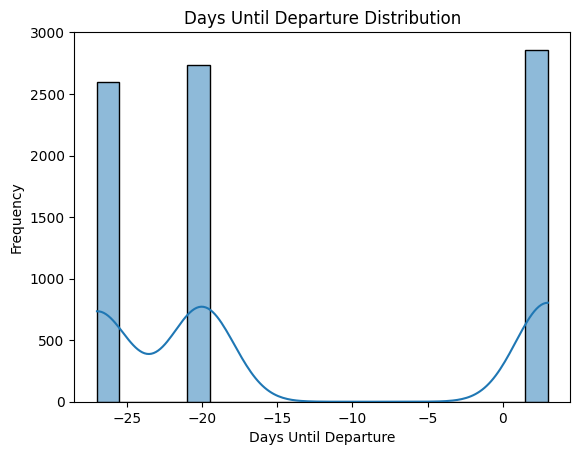

In [12]:
numerical_columns = df.select_dtypes(include = ['float64', 'int64']).columns

for column in numerical_columns:
    sns.histplot(df[column], kde = True, bins = 20)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

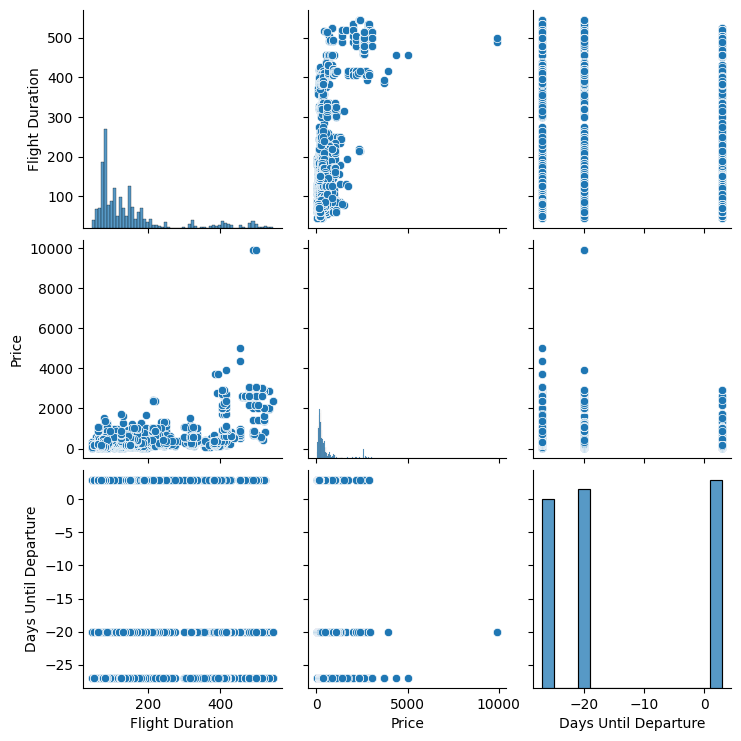

In [13]:
sns.pairplot(df[numerical_columns])
plt.show()

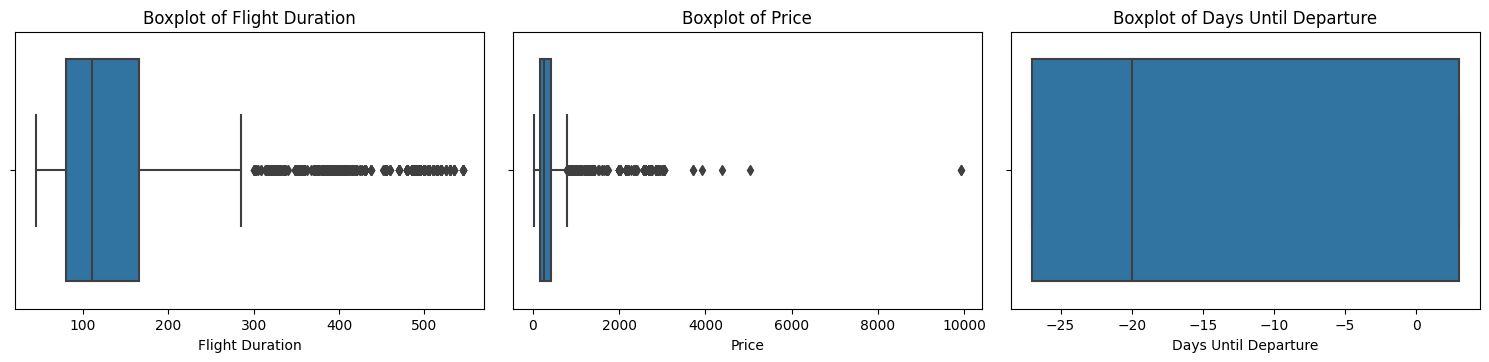

In [14]:
# Create boxplots for each numerical column
plt.figure(figsize = (15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

### **Average Price by Departure City**

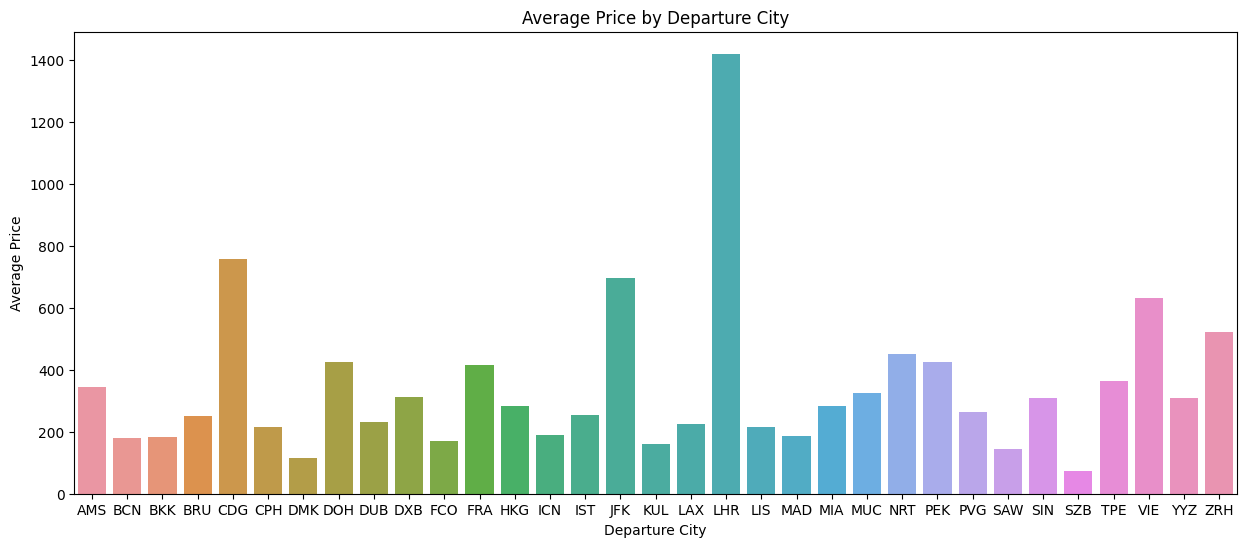

In [15]:
# Group by Departure City and calculate the mean for numerical columns
hub_stats = df.groupby('Departure City').agg({
    'Price': 'mean',
    'Flight Duration': 'mean',
}).reset_index()

# Average Cost by Departure City
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Departure City', y = 'Price', data = hub_stats)
plt.title('Average Price by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Price')
plt.show()

### **Average Flight Duration by Departure City**

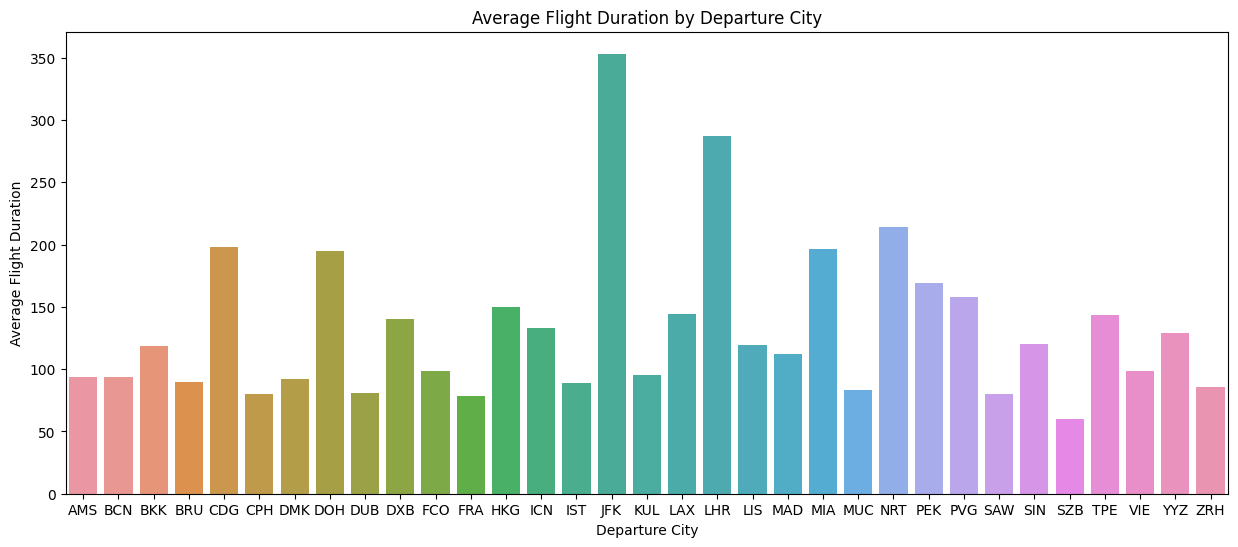

In [16]:
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Departure City', y = 'Flight Duration', data = hub_stats)
plt.title('Average Flight Duration by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Flight Duration')
plt.show()

### **Average Price and Flight Duration by Departure City**

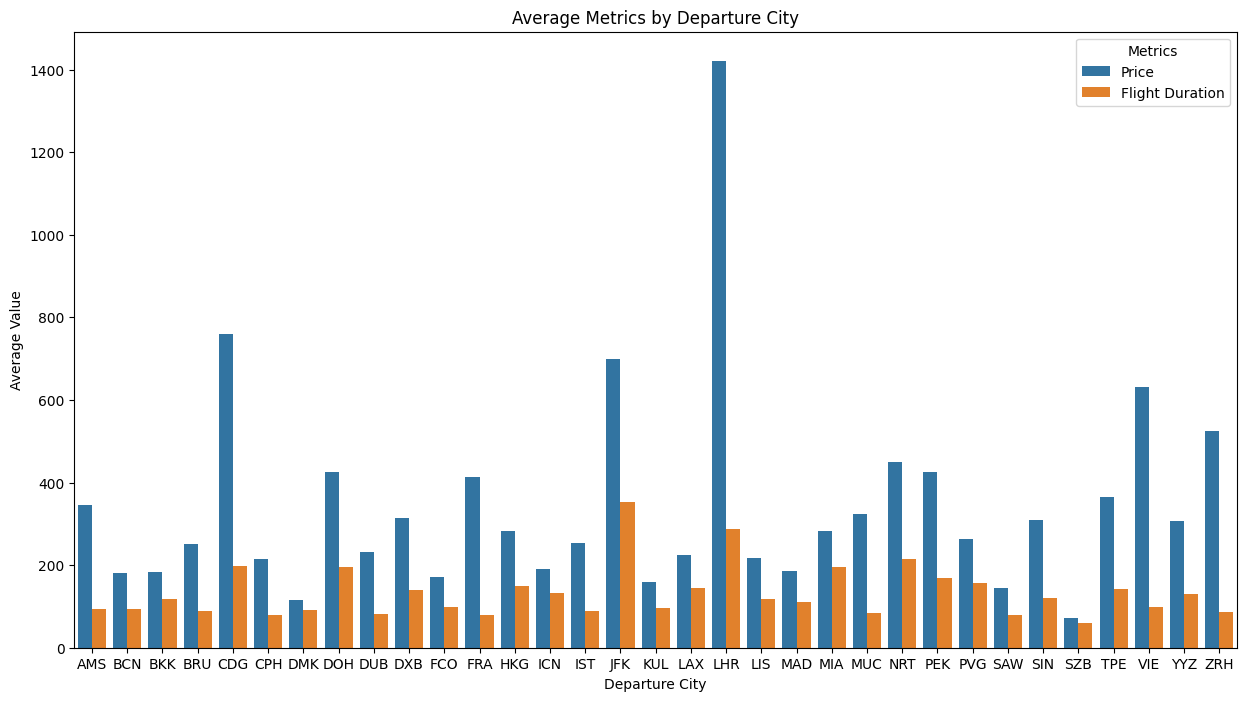

In [17]:
# Melt the dataframe to create a long-format dataframe for stacked bar chart
hub_stats_melted = hub_stats.melt(id_vars = 'Departure City', var_name = 'Metric', value_name = 'Value')

# Stacked bar chart for average cost, distance, and flight duration by departure city
plt.figure(figsize = (15, 8))
sns.barplot(x = 'Departure City', y = 'Value', hue = 'Metric', data = hub_stats_melted)
plt.title('Average Metrics by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Value')
plt.legend(title = 'Metrics', loc = 'upper right')
plt.show()

### **Flight Duration by Operating Carrier**

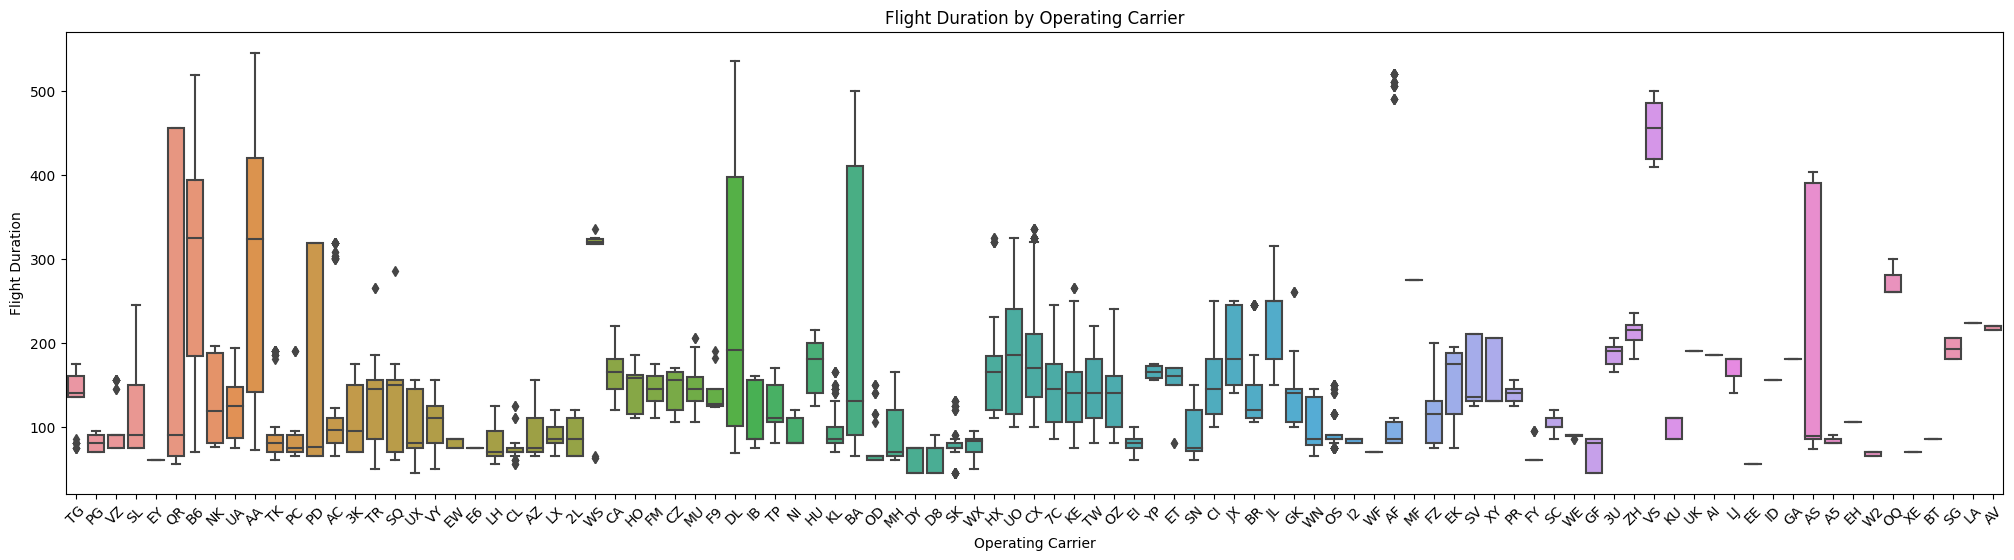

In [18]:
plt.figure(figsize = (25, 6))
sns.boxplot(x = 'Operating Carrier', y = 'Flight Duration', data = df)
plt.title('Flight Duration by Operating Carrier')
plt.xlabel('Operating Carrier')
plt.ylabel('Flight Duration')
plt.xticks(rotation = 45)
plt.show()

### **Flight Duration by Fare Class**

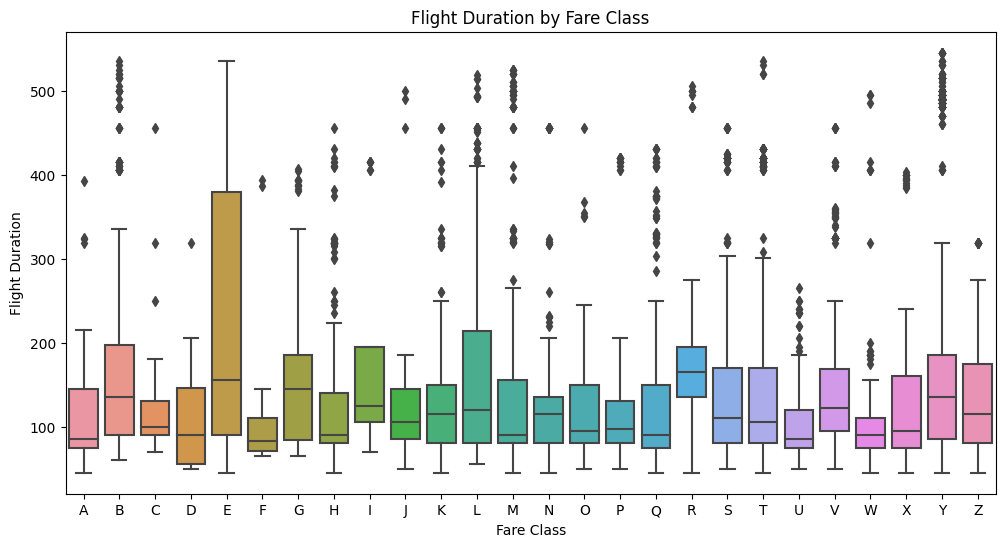

In [19]:
# Get the unique values of 'Fare Class' in alphabetical order
fare_class_order = sorted(df['Fare Class'].unique())

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Fare Class', y = 'Flight Duration', data = df, order = fare_class_order)
plt.title('Flight Duration by Fare Class')
plt.xlabel('Fare Class')
plt.ylabel('Flight Duration')
plt.show()

### **Distribution of Fare Class by Departure Date**

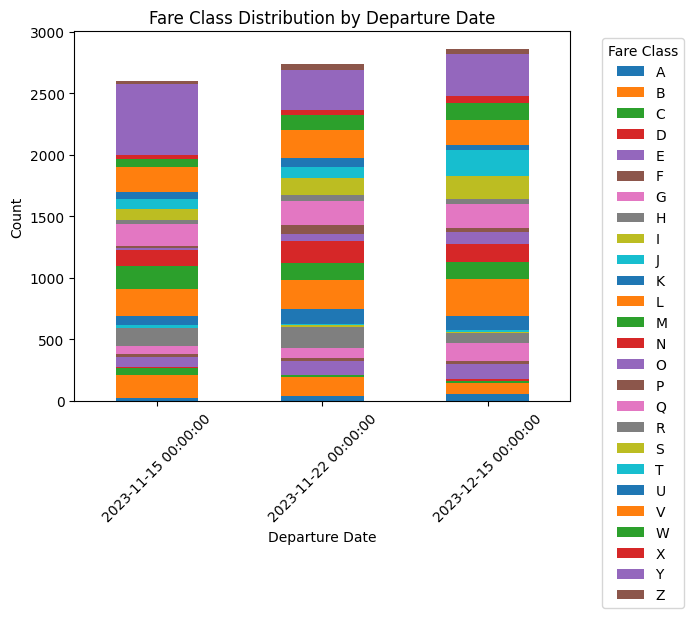

In [20]:
# Create a stacked dataframe
stacked_df = df.groupby(['Departure Date', 'Fare Class']).size().unstack()

# Plot stacked bar chart
stacked_df.plot(kind = 'bar', stacked = True)
plt.title('Fare Class Distribution by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.legend(title = 'Fare Class', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### **Heatmap of Numerical Features**

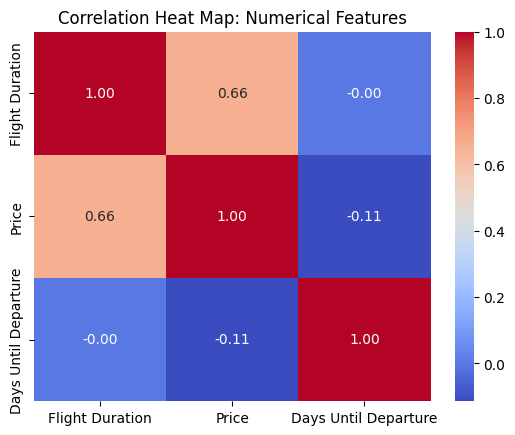

In [21]:
heatmap_data = df[numerical_columns]
sns.heatmap(heatmap_data.corr(), annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Heat Map: Numerical Features')
plt.show()

***

## **Data Preprocessing**

### **Handling Missing Values**

In [22]:
# Check for missing values
df.isnull().sum()

Departure City          0
Departure Date          0
Departure Time          0
Arrival Location        0
Arrival Date            0
Arrival Time            0
Flight Duration         0
Operating Carrier       0
Aircraft Type           0
Cabin Class             0
Fare Class              0
Price                   0
Days Until Departure    0
dtype: int64

There is no missing data, so there is no need for imputation or removal.


In [23]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicate rows (if any exist)
df.drop_duplicates(inplace = True)

Number of duplicate rows: 399


### **One Hot Encoding: Handling Categorical Features**

In [24]:
categorical_columns = ['Departure City', 'Operating Carrier', 'Aircraft Type', 'Cabin Class', 'Fare Class', 'Arrival Location']

df = pd.get_dummies(df, columns = categorical_columns)

### **Outliers**

Outliers were retained in the analysis because they could represent instances of higher-priced premium tickets or last-minute bookings. These extreme values, although atypical, may carry valuable information and insights, especially in industries like air travel where pricing dynamics can vary based on factors such as class, urgency, or special services. Keeping outliers allows for a more comprehensive understanding of the diverse pricing scenarios that might exist within the dataset.

Future studies may consider removing outliers through methods such as using Z-Score. Rows from the original dataframe where all the z-scores are less than 3 may be selected. Rows with z-scores greater than 3 are considered outliers and are excluded from the new dataframe. An example of this implementation is shown below.

In [25]:
'''
zscore(df[numerical_columns])
df_no_outliers = df[(z_scores < 3)]
'''

'\nzscore(df[numerical_columns])\ndf_no_outliers = df[(z_scores < 3)]\n'

### **Convert to DateTime Format**

In [26]:
df['Departure Time'] = df['Departure Time'].str.replace('Z', '', regex = False)
df['Arrival Time'] = df['Arrival Time'].str.replace('Z', '', regex = False)

In [27]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'], errors = 'coerce')
df['Departure Time'] = pd.to_datetime(df['Departure Time'] + '+0000', format = '%H:%M:%S%z', utc = True, errors = 'coerce')
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], errors = 'coerce')
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'] + '+0000', format = '%H:%M:%S%z', utc = True, errors = 'coerce')

In [28]:
df.dtypes

Departure Date               datetime64[ns]
Departure Time          datetime64[ns, UTC]
Arrival Date                 datetime64[ns]
Arrival Time            datetime64[ns, UTC]
Flight Duration                       int64
                               ...         
Arrival Location_VIE                  uint8
Arrival Location_YOW                  uint8
Arrival Location_YUL                  uint8
Arrival Location_YVR                  uint8
Arrival Location_ZRH                  uint8
Length: 316, dtype: object

In [29]:
# Convert datetime features to a numeric representation
df['Departure_date_numeric'] = (df['Departure Date'].astype('int64') // 10**9).astype('int32')
df['Arrival_date_numeric'] = (df['Arrival Date'].astype('int64') // 10**9).astype('int32')
df['Arrival_time_numeric'] = (df['Arrival Time'].astype('int64') // 10**9).astype('int32')
df['Departure_time_numeric'] = (df['Departure Time'].astype('int64') // 10**9).astype('int32')

In [30]:
print(df['Departure_date_numeric'])

0       1702598400
1       1702598400
2       1702598400
3       1702598400
4       1702598400
           ...    
8183    1700611200
8184    1700611200
8186    1700611200
8191    1700611200
8192    1700611200
Name: Departure_date_numeric, Length: 7796, dtype: int32


In [31]:
# Create a new dataframe that is a copy of the original dataframe
df2 = df.copy()

# Remove the original DateTime columns
columns_to_drop = ['Arrival Time', 'Arrival Date', 'Departure Date', 'Departure Time']
df2 = df2.drop(columns = columns_to_drop, axis = 1)
df2.head()

,Flight Duration,Price,Days Until Departure,Departure City_AMS,Departure City_BCN,Departure City_BKK,Departure City_BRU,Departure City_CDG,Departure City_CPH,Departure City_DMK,...,Arrival Location_USM,Arrival Location_VIE,Arrival Location_YOW,Arrival Location_YUL,Arrival Location_YVR,Arrival Location_ZRH,Departure_date_numeric,Arrival_date_numeric,Arrival_time_numeric,Departure_time_numeric
0,80,74.8,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1702598400,1702598400,2086015996,2086011196
1,80,94.8,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1702598400,1702598400,2086012096,2086007296
2,80,94.8,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1702598400,1702598400,2086027996,2086023196
3,80,105.8,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1702598400,1702598400,2086046596,2086041796
4,80,105.8,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1702598400,1702598400,2086019296,2086014496


In [32]:
df2.dtypes

Flight Duration             int64
Price                     float64
Days Until Departure        int64
Departure City_AMS          uint8
Departure City_BCN          uint8
                           ...   
Arrival Location_ZRH        uint8
Departure_date_numeric      int32
Arrival_date_numeric        int32
Arrival_time_numeric        int32
Departure_time_numeric      int32
Length: 316, dtype: object

***

## **Modeling**

### **Data Preparation**

#### **Train-Test Split**

In [33]:
target_column = 'Price'

# Features (X): Include all columns except "Price"
X = df2.drop(columns = [target_column])
# Target variable (y): "Price" column
y = df2[target_column]

# Split data into training (80%) and testing sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Display the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6236, 315)
X_test shape: (1560, 315)
y_train shape: (6236,)
y_test shape: (1560,)


### **Model Training**

#### **Random Forest**

In [34]:
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

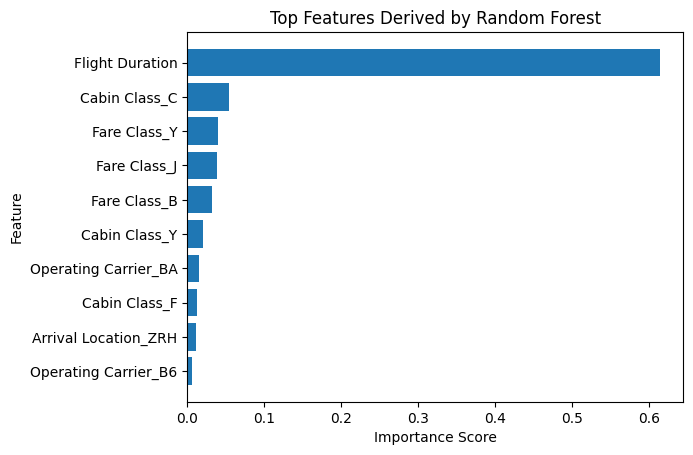

In [35]:
# Feature importance
feature_importances = rf_model.feature_importances_

top_n = 10
top_features = X.columns[np.argsort(feature_importances)[-top_n:]]

plt.barh(top_features, feature_importances[np.argsort(feature_importances)[-top_n:]])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title("Top Features Derived by Random Forest")
plt.show()

In [36]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

# Perform grid search
grid_search = GridSearchCV(rf_model, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_params

{'max_depth': None, 'n_estimators': 100}

In [37]:
best_rf_model = RandomForestRegressor(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    random_state = 42
)

In [38]:
X_train_top_ten = X_train[['Fare Class_L', 'Departure City_ZRH', 'Fare Class_M',
                       'Operating Carrier_OS', 'Cabin Class_Y', 'Cabin Class_C',
                       'Operating Carrier_BA', 'Fare Class_Y', 'Fare Class_B',
                       'Flight Duration']]

best_rf_model.fit(X_train_top_ten, y_train)

RandomForestRegressor(random_state=42)

In [39]:
X_test_top_ten = X_test[['Fare Class_L', 'Departure City_ZRH', 'Fare Class_M',
                       'Operating Carrier_OS', 'Cabin Class_Y', 'Cabin Class_C',
                       'Operating Carrier_BA', 'Fare Class_Y', 'Fare Class_B',
                       'Flight Duration']]

y_pred = best_rf_model.predict(X_test_top_ten)

In [40]:
X_train_top_ten = X_train[['Fare Class_L', 'Departure City_ZRH', 'Fare Class_M',
                            'Operating Carrier_OS', 'Cabin Class_Y', 'Cabin Class_C',
                            'Operating Carrier_BA', 'Fare Class_Y', 'Fare Class_B',
                            'Flight Duration']]

X_test_top_ten = X_test[['Fare Class_L', 'Departure City_ZRH', 'Fare Class_M',
                          'Operating Carrier_OS', 'Cabin Class_Y', 'Cabin Class_C',
                          'Operating Carrier_BA', 'Fare Class_Y', 'Fare Class_B',
                          'Flight Duration']]

#### **K-Nearest Neighbors (k-NN)**

In [41]:
knn_model = KNeighborsRegressor(n_neighbors = 5)
knn_model.fit(X_train_top_ten, y_train)

KNeighborsRegressor()

#### **Decision Tree**

In [42]:
dt_model = DecisionTreeRegressor(max_depth = 3)
dt_model.fit(X_train_top_ten, y_train)

DecisionTreeRegressor(max_depth=3)

#### **Linear Regression**

In [43]:
lr_model = LinearRegression()
lr_model.fit(X_train_top_ten, y_train)

LinearRegression()

#### **Lasso Regression**

In [44]:
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(X_train_top_ten, y_train)

Lasso(alpha=0.1)

#### **Ridge Regression**

In [45]:
ridge_model = Ridge(alpha = 0.1)
ridge_model.fit(X_train_top_ten, y_train)

Ridge(alpha=0.1)

#### **Elastic Net**

In [46]:
en_model = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
en_model.fit(X_train_top_ten, y_train)

ElasticNet(alpha=0.1)

#### **Extreme Gradient Boosting (XGBoost)**

In [47]:
xgb_model = XGBRegressor(objective = 'reg:squarederror')
xgb_model.fit(X_train_top_ten, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### **Neural Networks**

In [48]:
nn_model = MLPRegressor(hidden_layer_sizes = (100, ), max_iter = 500)
nn_model.fit(X_train_top_ten, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(max_iter=500)

#### **Support Vector Regression (SVR)**

In [49]:
svr_model = SVR(kernel = 'linear')
svr_model.fit(X_train_top_ten, y_train)

SVR(kernel='linear')

#### **Gradient Boosting**

In [50]:
gb_model = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 42)
gb_model.fit(X_train_top_ten, y_train)

GradientBoostingRegressor(random_state=42)

#### **Training Set Performance**

In [51]:
# Define a list of models
models = [
    ("Random Forest", RandomForestRegressor(n_estimators = 100, random_state = 42)),
    ("k-Nearest Neighbors (k-NN)", KNeighborsRegressor(n_neighbors = 5)),
    ("Decision Tree", DecisionTreeRegressor(max_depth = 3)),
    ("Linear Regression", LinearRegression()),
    ("Lasso Regression", Lasso(alpha = 0.1)),
    ("Ridge Regression", Ridge(alpha = 0.1)),
    ("Elastic Net", ElasticNet(alpha = 0.1, l1_ratio = 0.5)),
    ("XGBoost", XGBRegressor(objective = 'reg:squarederror')),
    ("Neural Networks", MLPRegressor(hidden_layer_sizes = (100, ), max_iter = 500)),
    ("Support Vector Regression (SVR)", SVR(kernel = 'linear')),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 42))
]

In [52]:
# Create an empty list to store dictionaries of metrics
metrics_list = []

# Loop over models
for model_name, model in models:
    # Train the model and make predictions on the training set
    model.fit(X_train_top_ten, y_train)
    y_pred_train = model.predict(X_train_top_ten)

    # Calculate performance metrics on the training set
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared = False)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Append metrics to the list
    metrics_list.append({
        'Model': model_name,
        'MSE (Train)': mse_train,
        'RMSE (Train)': rmse_train,
        'MAE (Train)': mae_train,
        'R2 (Train)': r2_train
    })

# Create a dataframe from the list of metrics
metrics_df_train = pd.DataFrame(metrics_list)
metrics_df_train

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,MSE (Train),RMSE (Train),MAE (Train),R2 (Train)
0,Random Forest,17085.660947,130.712130,81.105861,0.922095
1,k-Nearest Neighbors (k-NN),39621.602903,199.051759,96.187104,0.819338
2,Decision Tree,59599.060299,244.129188,147.524461,0.728247
3,Linear Regression,97941.202898,312.955593,190.705454,0.553420
4,Lasso Regression,97943.570308,312.959375,190.463383,0.553409
5,Ridge Regression,97941.212366,312.955608,190.694298,0.553420
6,Elastic Net,107841.045900,328.391604,186.863945,0.508279
7,XGBoost,16368.981743,127.941321,80.998241,0.925363
8,Neural Networks,68795.720799,262.289384,147.864082,0.686314
9,Support Vector Regression (SVR),145895.095634,381.962165,160.045851,0.334765


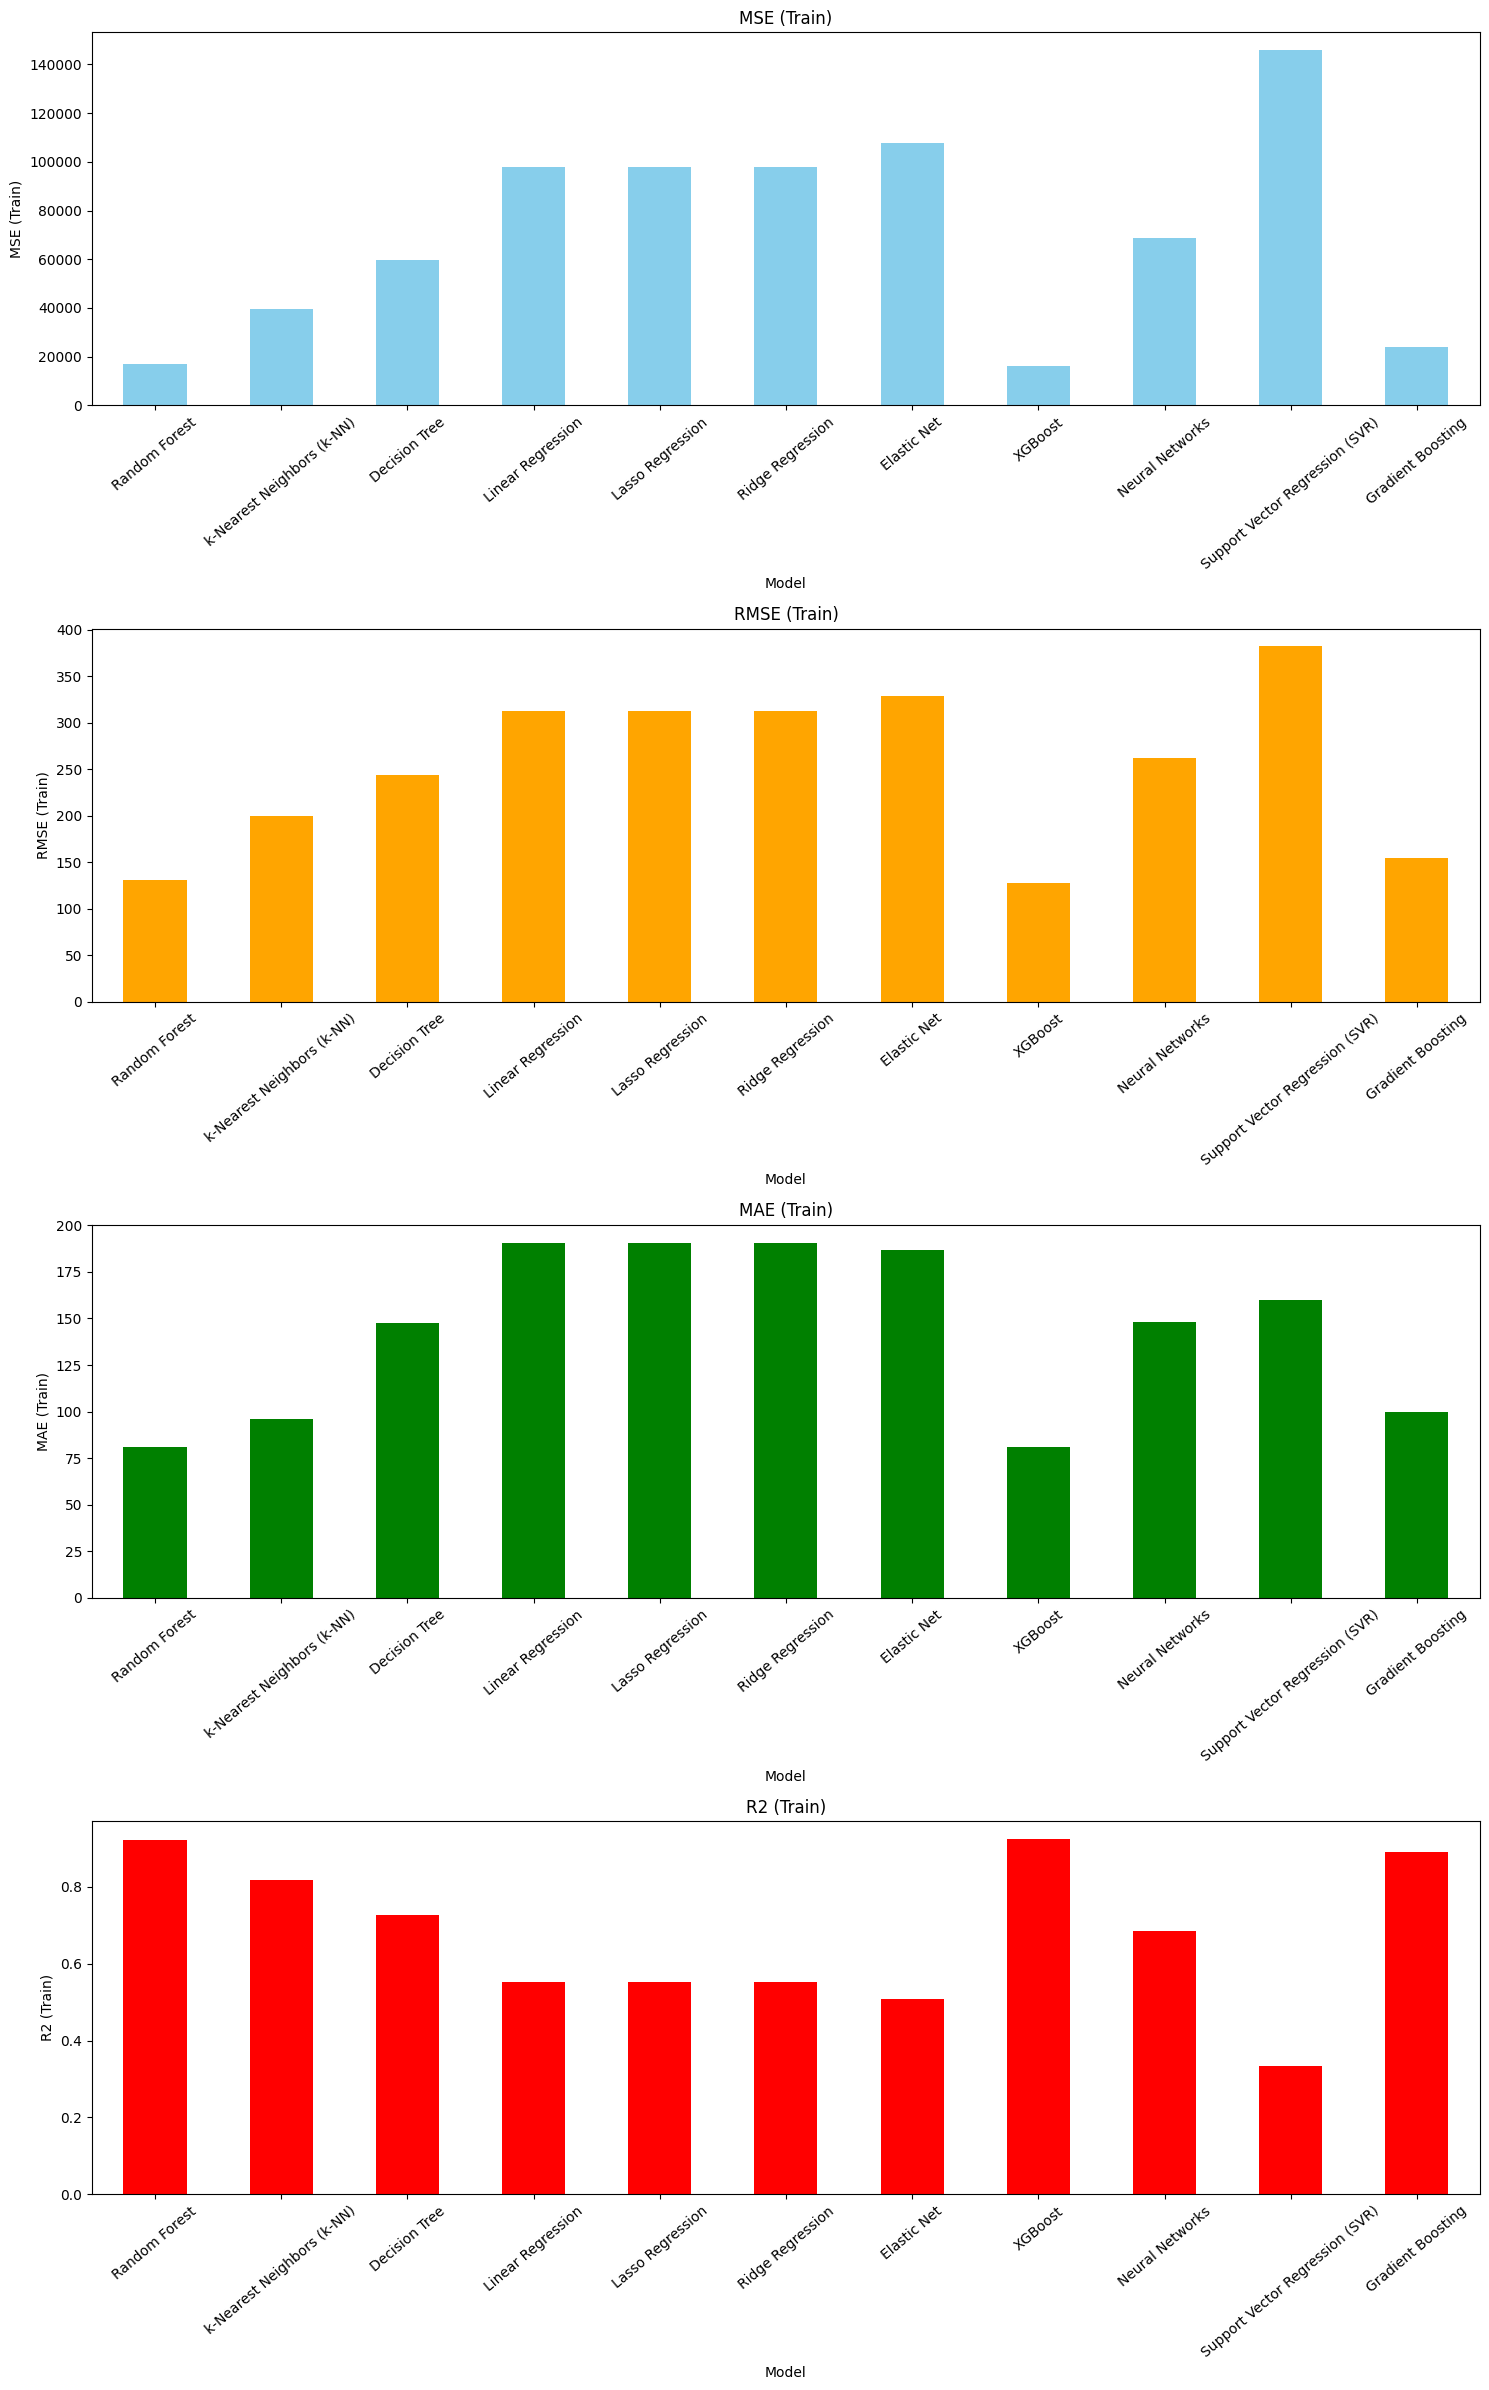

In [53]:
# Set the model names as the index
metrics_df_train.set_index('Model', inplace = True)

# Define the metrics to plot
metrics_to_plot_train = ['MSE (Train)', 'RMSE (Train)', 'MAE (Train)', 'R2 (Train)']
colors = ['skyblue', 'orange', 'green', 'red']

# Create subplots for each metric
fig, axes = plt.subplots(nrows = len(metrics_to_plot_train), ncols = 1, figsize = (15, 6 * len(metrics_to_plot_train)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_to_plot_train):
    metrics_df_train[metric].plot(kind = 'bar', ax=axes[i], color = colors[i])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis='x', rotation = 40)

plt.tight_layout()
plt.show()

#### **Feature Scaling on Training Set**

In [54]:
# Initialize a StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the models on the scaled data
for model_name, model in models:
    model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e+05, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:
# Create an empty list to store dictionaries of metrics for the scaled training set
metrics_list_scaled = []

# Loop over models
for model_name, model in models:
    # Make predictions on the scaled training set
    y_pred_train_scaled = model.predict(X_train_scaled)

    # Calculate performance metrics on the scaled training set
    mse_train_scaled = mean_squared_error(y_train, y_pred_train_scaled)
    rmse_train_scaled = mean_squared_error(y_train, y_pred_train_scaled, squared = False)
    mae_train_scaled = mean_absolute_error(y_train, y_pred_train_scaled)
    r2_train_scaled = r2_score(y_train, y_pred_train_scaled)

    # Append metrics to the list
    metrics_list_scaled.append({
        'Model': model_name,
        'MSE (Train Scaled)': mse_train_scaled,
        'RMSE (Train Scaled)': rmse_train_scaled,
        'MAE (Train Scaled)': mae_train_scaled,
        'R2 (Train Scaled)': r2_train_scaled
    })

# Create a dataframe from the list of metrics for the scaled training set
metrics_df_train_scaled = pd.DataFrame(metrics_list_scaled)
metrics_df_train_scaled

,Model,MSE (Train Scaled),RMSE (Train Scaled),MAE (Train Scaled),R2 (Train Scaled)
0,Random Forest,1509.761632,38.855651,12.026967,0.993116
1,k-Nearest Neighbors (k-NN),24196.736025,155.553001,56.288754,0.889671
2,Decision Tree,59599.060299,244.129188,147.524461,0.728247
3,Linear Regression,41450.424699,203.593774,101.733136,0.810999
4,Lasso Regression,41588.057280,203.931501,101.845272,0.810372
5,Ridge Regression,41421.651364,203.523098,101.737122,0.811131
6,Elastic Net,42694.803062,206.627208,101.506211,0.805325
7,XGBoost,1778.655462,42.174109,26.471239,0.991890
8,Neural Networks,1518.433723,38.967085,14.799499,0.993076
9,Support Vector Regression (SVR),53368.851303,231.016994,87.127777,0.756655


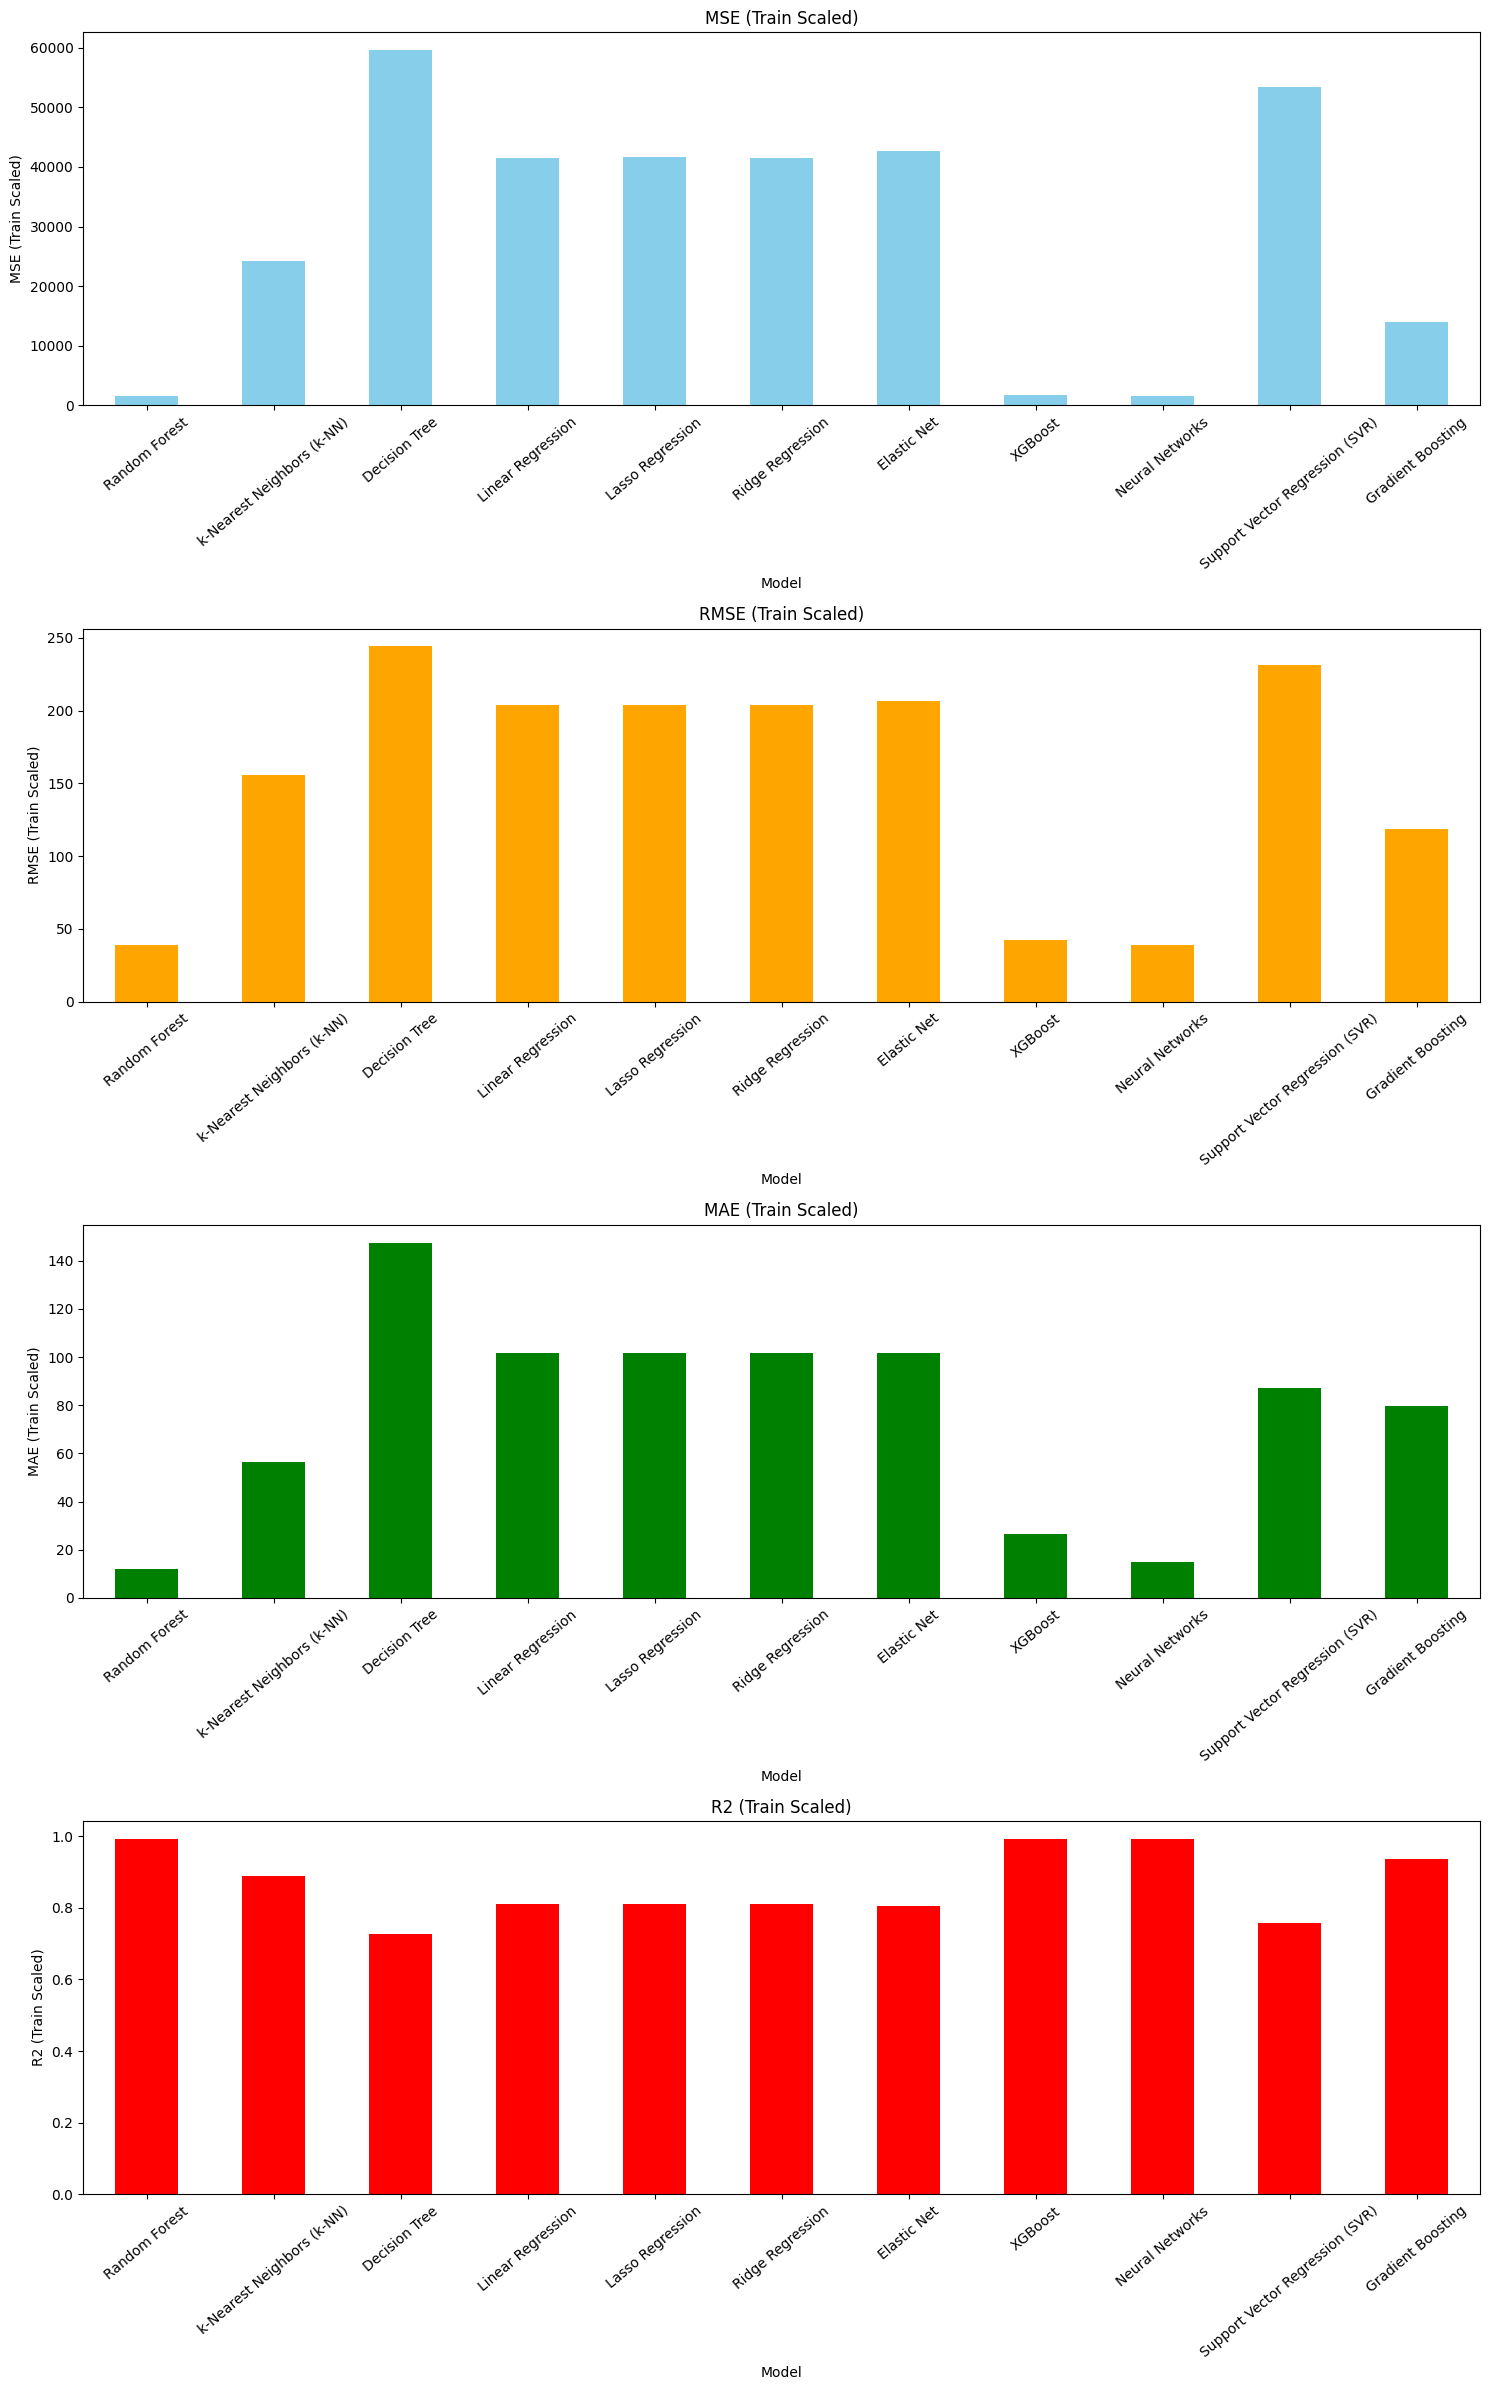

In [56]:
# Set the model names as the index
metrics_df_train_scaled.set_index('Model', inplace = True)

# Define the metrics to plot for the scaled training set
metrics_to_plot_train = ['MSE (Train Scaled)', 'RMSE (Train Scaled)', 'MAE (Train Scaled)', 'R2 (Train Scaled)']

# Create subplots for each metric
fig, axes = plt.subplots(nrows = len(metrics_to_plot_train), ncols = 1, figsize = (15, 6 * len(metrics_to_plot_train)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_to_plot_train):
    metrics_df_train_scaled[metric].plot(kind = 'bar', ax = axes[i], color = colors[i])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis = 'x', rotation = 40)

plt.tight_layout()
plt.show()

### **5-Fold Cross Validation**

In [57]:
# Initialize an empty list to store results
results = []

# Perform cross-validation
for model_name, model in models:
    print(f"Model: {model_name}")

    # Perform 5-fold cross validation
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

    # Initialize lists to store metric scores for each fold
    mse_scores, rmse_scores, mae_scores, r2_scores = [], [], [], []

    # Loop over folds
    for train_index, test_index in kf.split(X_train_top_ten, y_train):
        X_train_fold, X_test_fold = X_train_top_ten.iloc[train_index], X_train_top_ten.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train the model and make predictions
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        # Calculate metrics for this fold
        mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
        rmse_fold = np.sqrt(mse_fold)
        mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
        r2_fold = r2_score(y_test_fold, y_pred_fold)

        # Append scores to lists
        mse_scores.append(mse_fold)
        rmse_scores.append(rmse_fold)
        mae_scores.append(mae_fold)
        r2_scores.append(r2_fold)

    # Calculate scores across folds
    mean_mse = np.mean(mse_scores)
    mean_rmse = np.mean(rmse_scores)
    mean_mae = np.mean(mae_scores)
    mean_r2 = np.mean(r2_scores)

    # Append results to the list
    results.append({
        'Model': model_name,
        'Mean MSE': mean_mse,
        'Mean RMSE': mean_rmse,
        'Mean MAE': mean_mae,
        'Mean R2': mean_r2
    })

# Create a dataframe from the list of results
results_df = pd.DataFrame(results)
results_df

Model: Random Forest
Model: k-Nearest Neighbors (k-NN)
Model: Decision Tree
Model: Linear Regression
Model: Lasso Regression
Model: Ridge Regression
Model: Elastic Net
Model: XGBoost
Model: Neural Networks


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Model: Support Vector Regression (SVR)
Model: Gradient Boosting


,Model,Mean MSE,Mean RMSE,Mean MAE,Mean R2
0,Random Forest,28786.442935,168.448195,93.782383,0.865818
1,k-Nearest Neighbors (k-NN),58233.911177,233.663885,110.386211,0.750489
2,Decision Tree,64087.065469,252.315154,152.417471,0.695630
3,Linear Regression,98859.740166,310.791253,190.969436,0.552186
4,Lasso Regression,98863.449779,310.790139,190.722145,0.552207
5,Ridge Regression,98859.331412,310.790118,190.954851,0.552190
6,Elastic Net,108778.630774,326.122289,187.087638,0.506578
7,XGBoost,25863.768793,160.019981,92.002716,0.877375
8,Neural Networks,67835.345840,254.750364,144.527223,0.701967
9,Support Vector Regression (SVR),147980.072305,379.598966,161.575271,0.334022


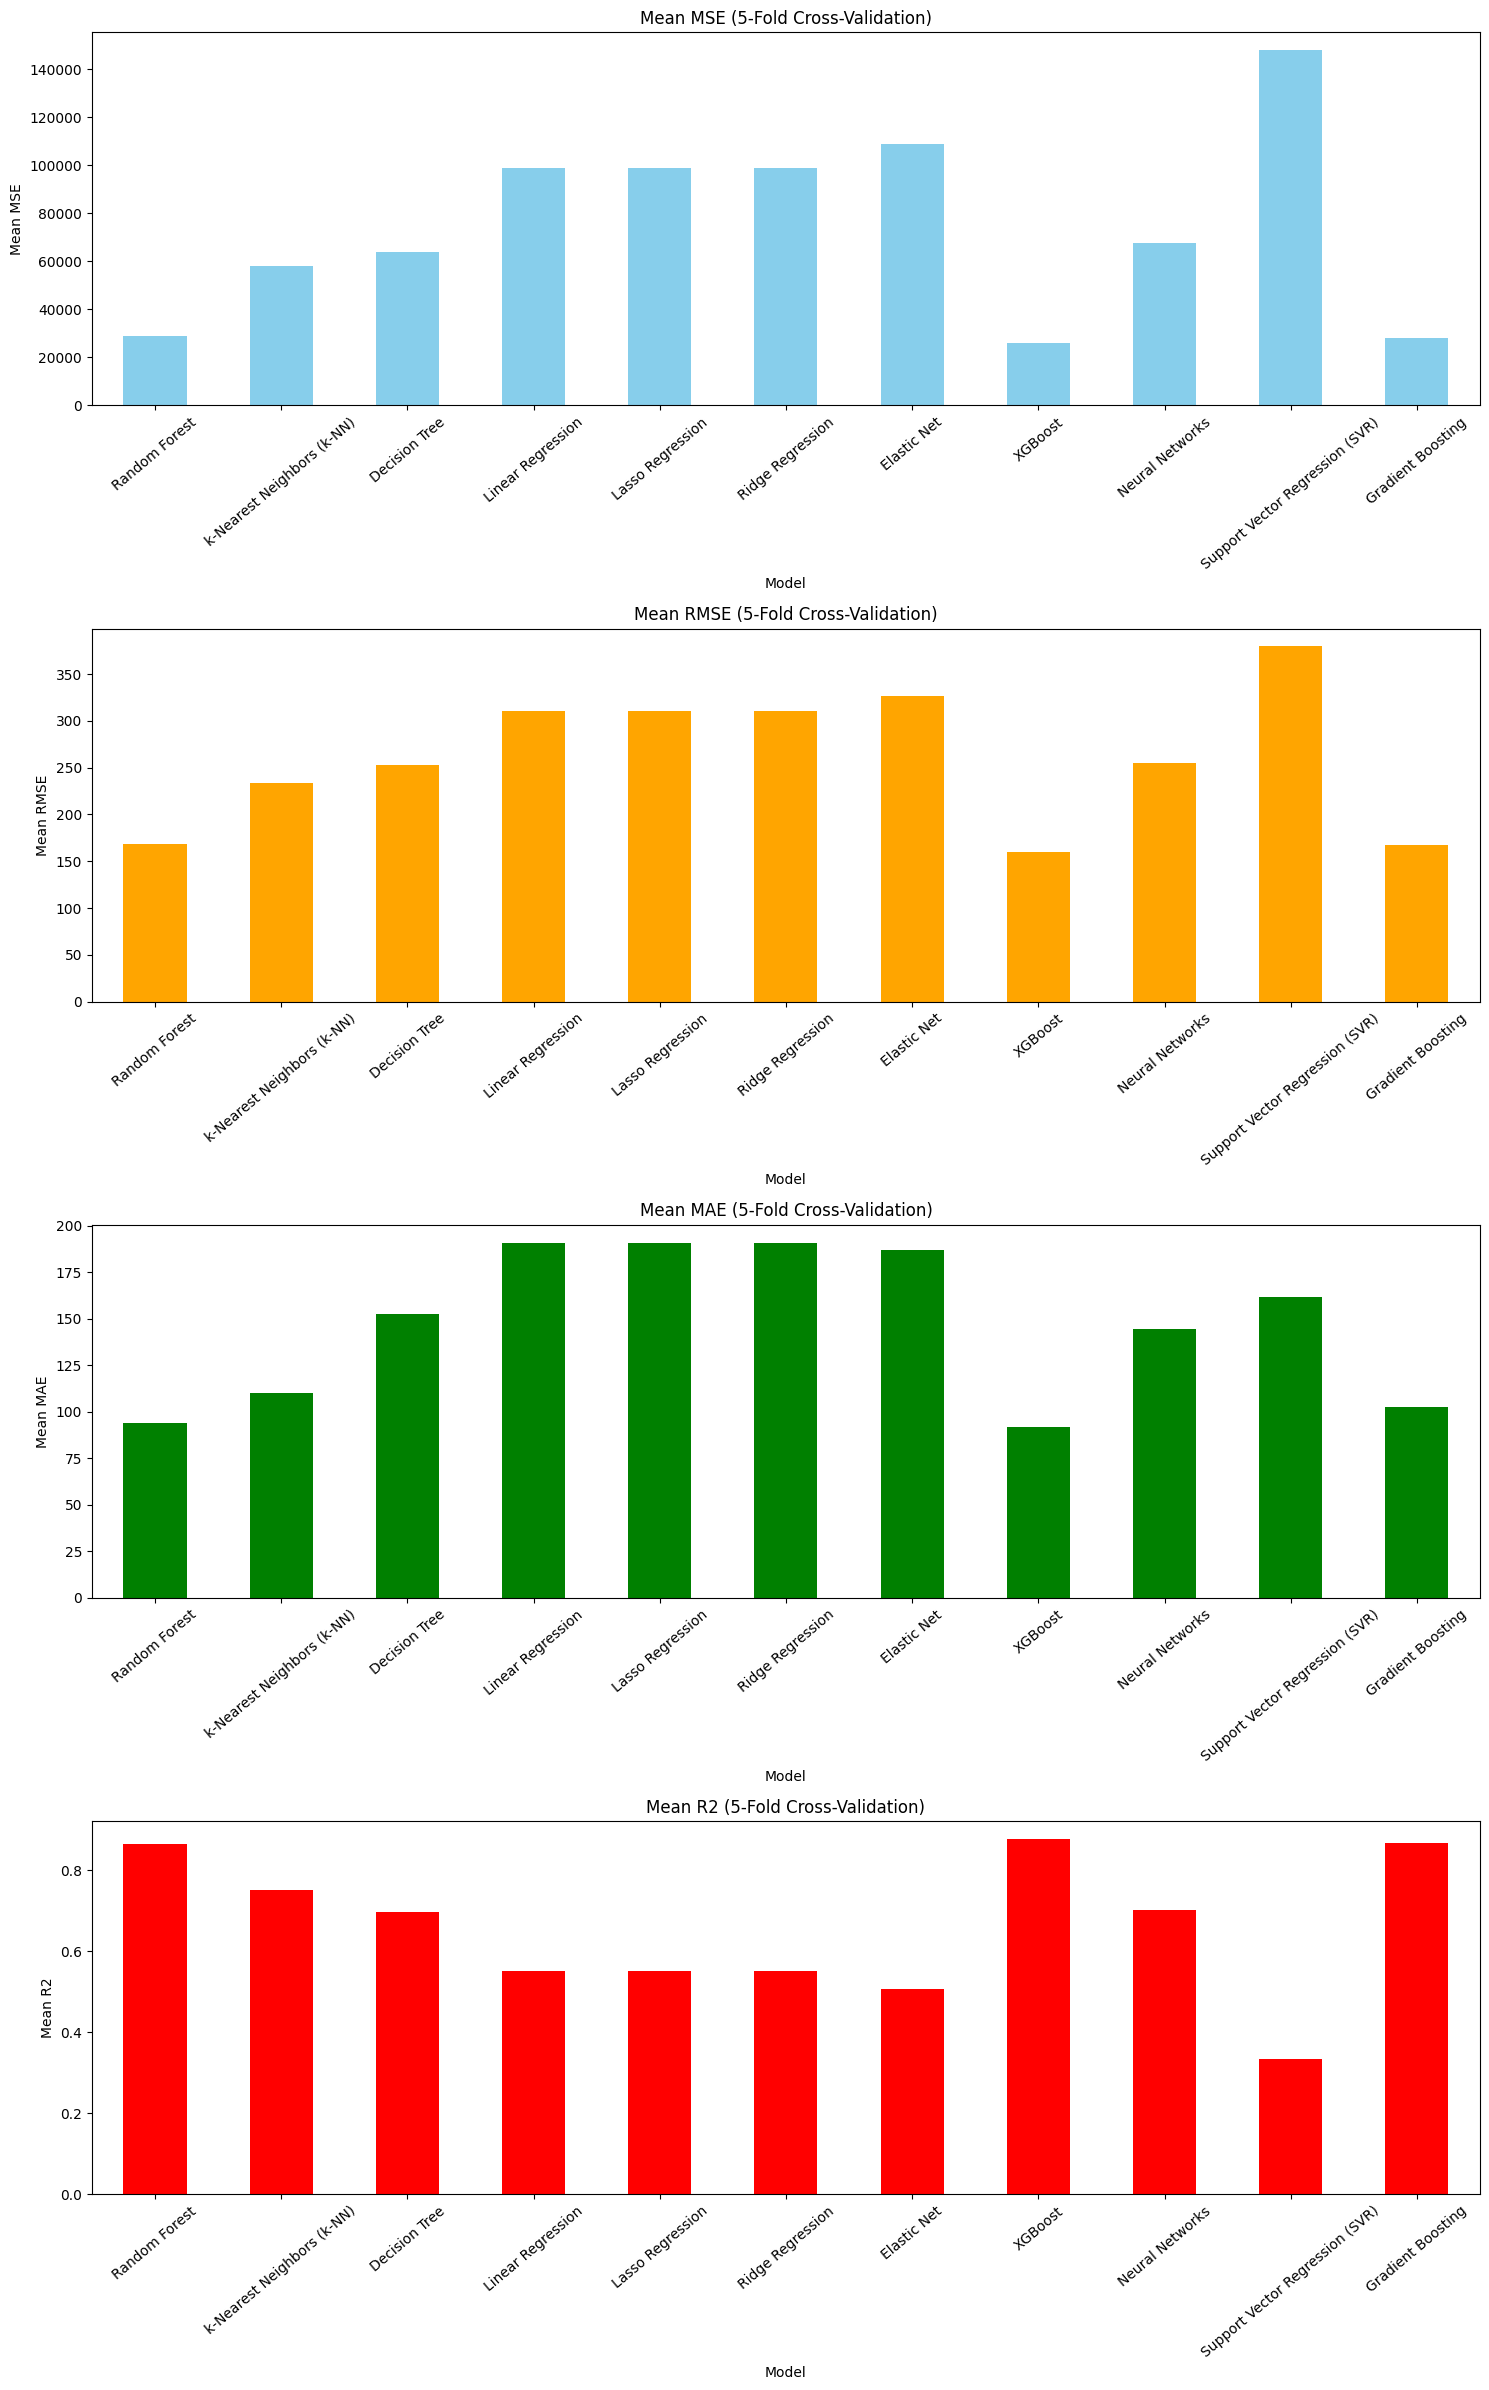

In [58]:
# Set the model names as the index
results_df.set_index('Model', inplace = True)

# Define the metrics to plot
metrics_to_plot_cv = ['Mean MSE', 'Mean RMSE', 'Mean MAE', 'Mean R2']

# Create subplots for each metric
fig, axes = plt.subplots(nrows = len(metrics_to_plot_cv), ncols = 1, figsize = (15, 6 * len(metrics_to_plot_cv)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_to_plot_cv):
    results_df[metric].plot(kind = 'bar', ax = axes[i], color = colors[i])
    axes[i].set_title(f'{metric} (5-Fold Cross-Validation)')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis='x', rotation = 40)

plt.tight_layout()
plt.show()

### **Model Testing**

#### **Random Forest**

In [59]:
y_pred_rf = rf_model.predict(X_test)

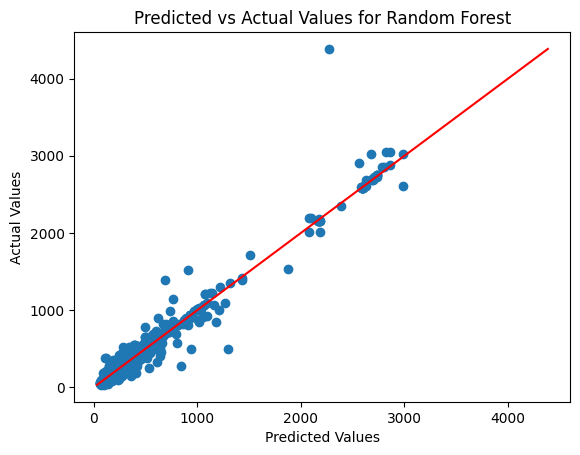

In [60]:
# Plotting actual vs predicted values
plt.scatter(y_pred_rf, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Random Forest")
plt.show()

#### **k-Nearest Neighbors (k-NN)**

In [61]:
y_pred_knn = knn_model.predict(X_test_top_ten)

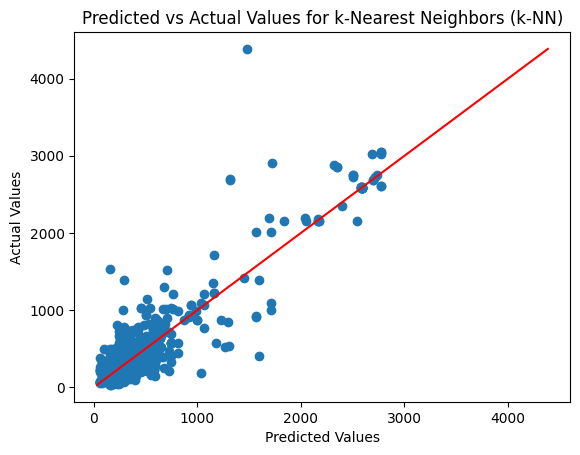

In [62]:
# Plotting actual vs predicted values
plt.scatter(y_pred_knn, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for k-Nearest Neighbors (k-NN)")
plt.show()

#### **Decision Tree**

In [63]:
y_pred_dt = dt_model.predict(X_test_top_ten)

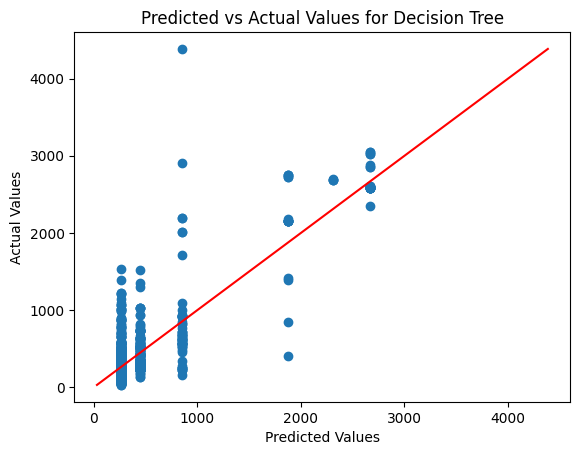

In [64]:
# Plotting actual vs predicted values
plt.scatter(y_pred_dt, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Decision Tree")
plt.show()

#### **Linear Regression**

In [65]:
y_pred_lr = lr_model.predict(X_test_top_ten)

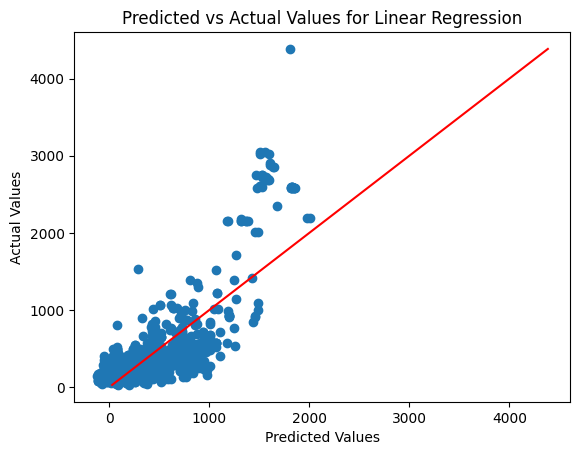

In [66]:
# Plotting actual vs predicted values
plt.scatter(y_pred_lr, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Linear Regression")
plt.show()

#### **Lasso Regression**

In [67]:
y_pred_lasso = lasso_model.predict(X_test_top_ten)

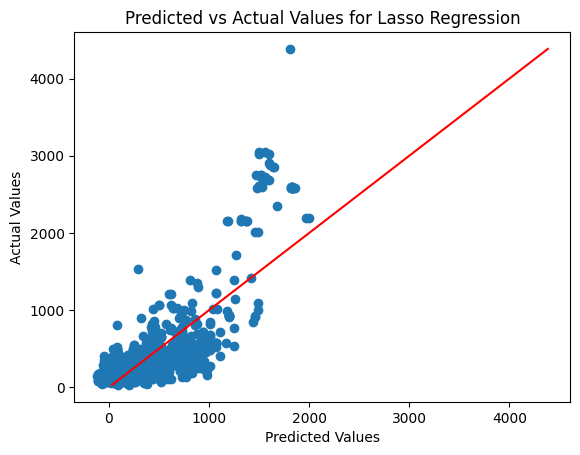

In [68]:
# Plotting actual vs predicted values
plt.scatter(y_pred_lasso, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Lasso Regression")
plt.show()

#### **Ridge Regression**

In [69]:
y_pred_ridge = ridge_model.predict(X_test_top_ten)

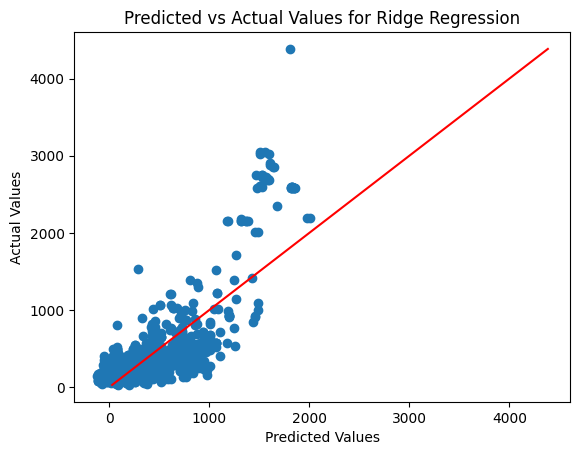

In [70]:
# Plotting actual vs predicted values
plt.scatter(y_pred_ridge, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Ridge Regression")
plt.show()

#### **Elastic Net**

In [71]:
y_pred_en = en_model.predict(X_test_top_ten)

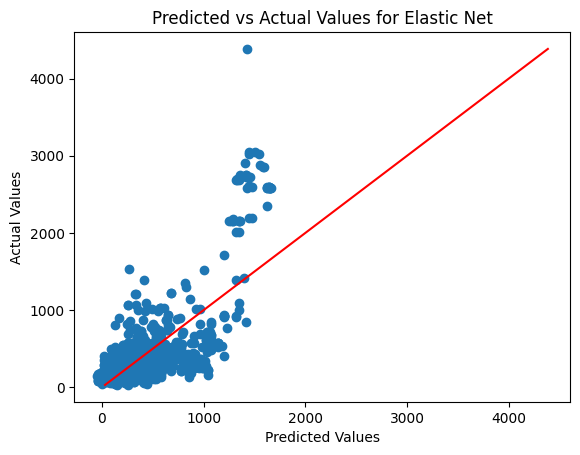

In [72]:
# Plotting actual vs predicted values
plt.scatter(y_pred_en, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Elastic Net")
plt.show()

#### **Extreme Gradient Boosting (XGBoost)**

In [73]:
y_pred_xgb = xgb_model.predict(X_test_top_ten)

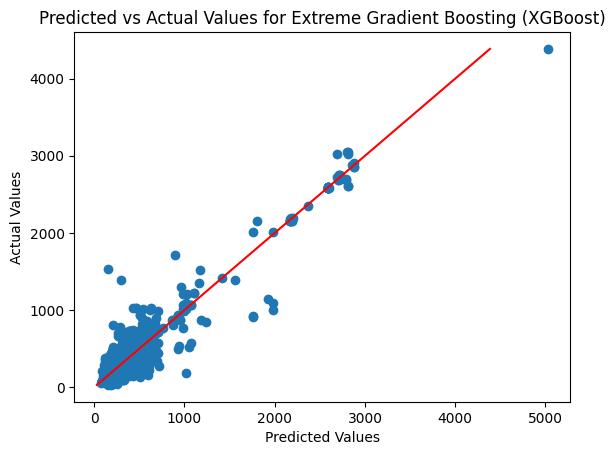

In [74]:
# Plotting actual vs predicted values
plt.scatter(y_pred_xgb, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Extreme Gradient Boosting (XGBoost)")
plt.show()

#### **Neural Networks**

In [75]:
y_pred_nn = nn_model.predict(X_test_top_ten)

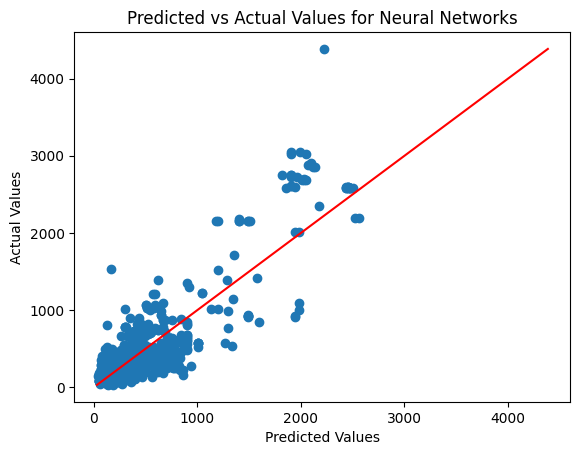

In [76]:
# Plotting actual vs predicted values
plt.scatter(y_pred_nn, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Neural Networks")
plt.show()

#### **Support Vector Regression (SVR)**

In [77]:
y_pred_svr = svr_model.predict(X_test_top_ten)

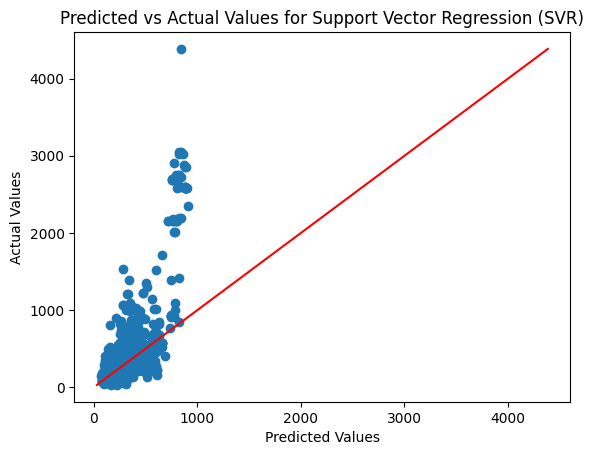

In [78]:
# Plotting actual vs predicted values
plt.scatter(y_pred_svr, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Support Vector Regression (SVR)")
plt.show()

#### **Gradient Boosting**

In [79]:
y_pred_gb = gb_model.predict(X_test_top_ten)

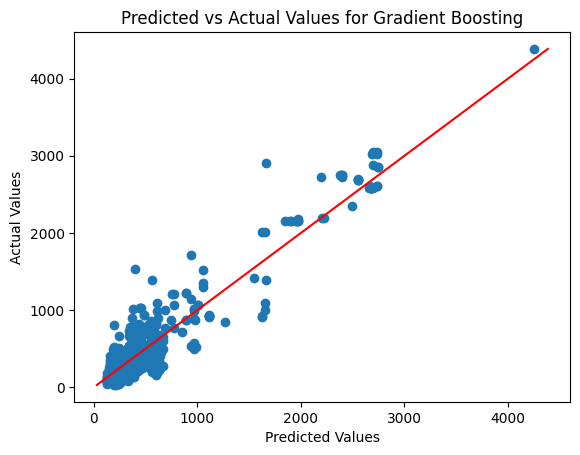

In [80]:
# Plotting actual vs predicted values
plt.scatter(y_pred_gb, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Predicted vs Actual Values for Gradient Boosting")
plt.show()

#### **Test Set Performance**

In [81]:
# Define a list of models
models = [
    ("Random Forest", RandomForestRegressor(n_estimators = 100, random_state = 42)),
    ("k-Nearest Neighbors (k-NN)", KNeighborsRegressor(n_neighbors = 5)),
    ("Decision Tree", DecisionTreeRegressor(max_depth = 3)),
    ("Linear Regression", LinearRegression()),
    ("Lasso Regression", Lasso(alpha = 0.1)),
    ("Ridge Regression", Ridge(alpha = 0.1)),
    ("Elastic Net", ElasticNet(alpha = 0.1, l1_ratio = 0.5)),
    ("XGBoost", XGBRegressor(objective = 'reg:squarederror')),
    ("Neural Networks", MLPRegressor(hidden_layer_sizes = (100, ), max_iter = 500)),
    ("Support Vector Regression (SVR)", SVR(kernel = 'linear')),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 42))
]

In [82]:
# Create an empty list to store dictionaries of metrics
metrics_list_test = []

# Loop over models
for model_name, model in models:
    # Train the model and make predictions on the test set
    model.fit(X_train_top_ten, y_train)
    y_pred_test = model.predict(X_test_top_ten)

    # Calculate performance metrics on the test set
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Append metrics to the list
    metrics_list_test.append({
        'Model': model_name,
        'MSE (Test)': mse_test,
        'RMSE (Test)': rmse_test,
        'MAE (Test)': mae_test,
        'R2 (Test)': r2_test
    })

# Create a dataframe from the list of metrics
metrics_df_test = pd.DataFrame(metrics_list_test)
metrics_df_test

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,MSE (Test),RMSE (Test),MAE (Test),R2 (Test)
0,Random Forest,19410.165092,139.320369,89.041332,0.903624
1,k-Nearest Neighbors (k-NN),31859.466782,178.492204,101.239292,0.841811
2,Decision Tree,55910.684052,236.454402,146.420291,0.722391
3,Linear Regression,79882.583062,282.635070,190.136004,0.603365
4,Lasso Regression,79864.864428,282.603723,189.869395,0.603453
5,Ridge Regression,79881.824679,282.633729,190.124426,0.603369
6,Elastic Net,88428.390520,297.369115,184.457208,0.560934
7,XGBoost,19538.270831,139.779365,89.235803,0.902988
8,Neural Networks,44992.170071,212.113578,133.808534,0.776604
9,Support Vector Regression (SVR),126124.448865,355.140041,158.608866,0.373764


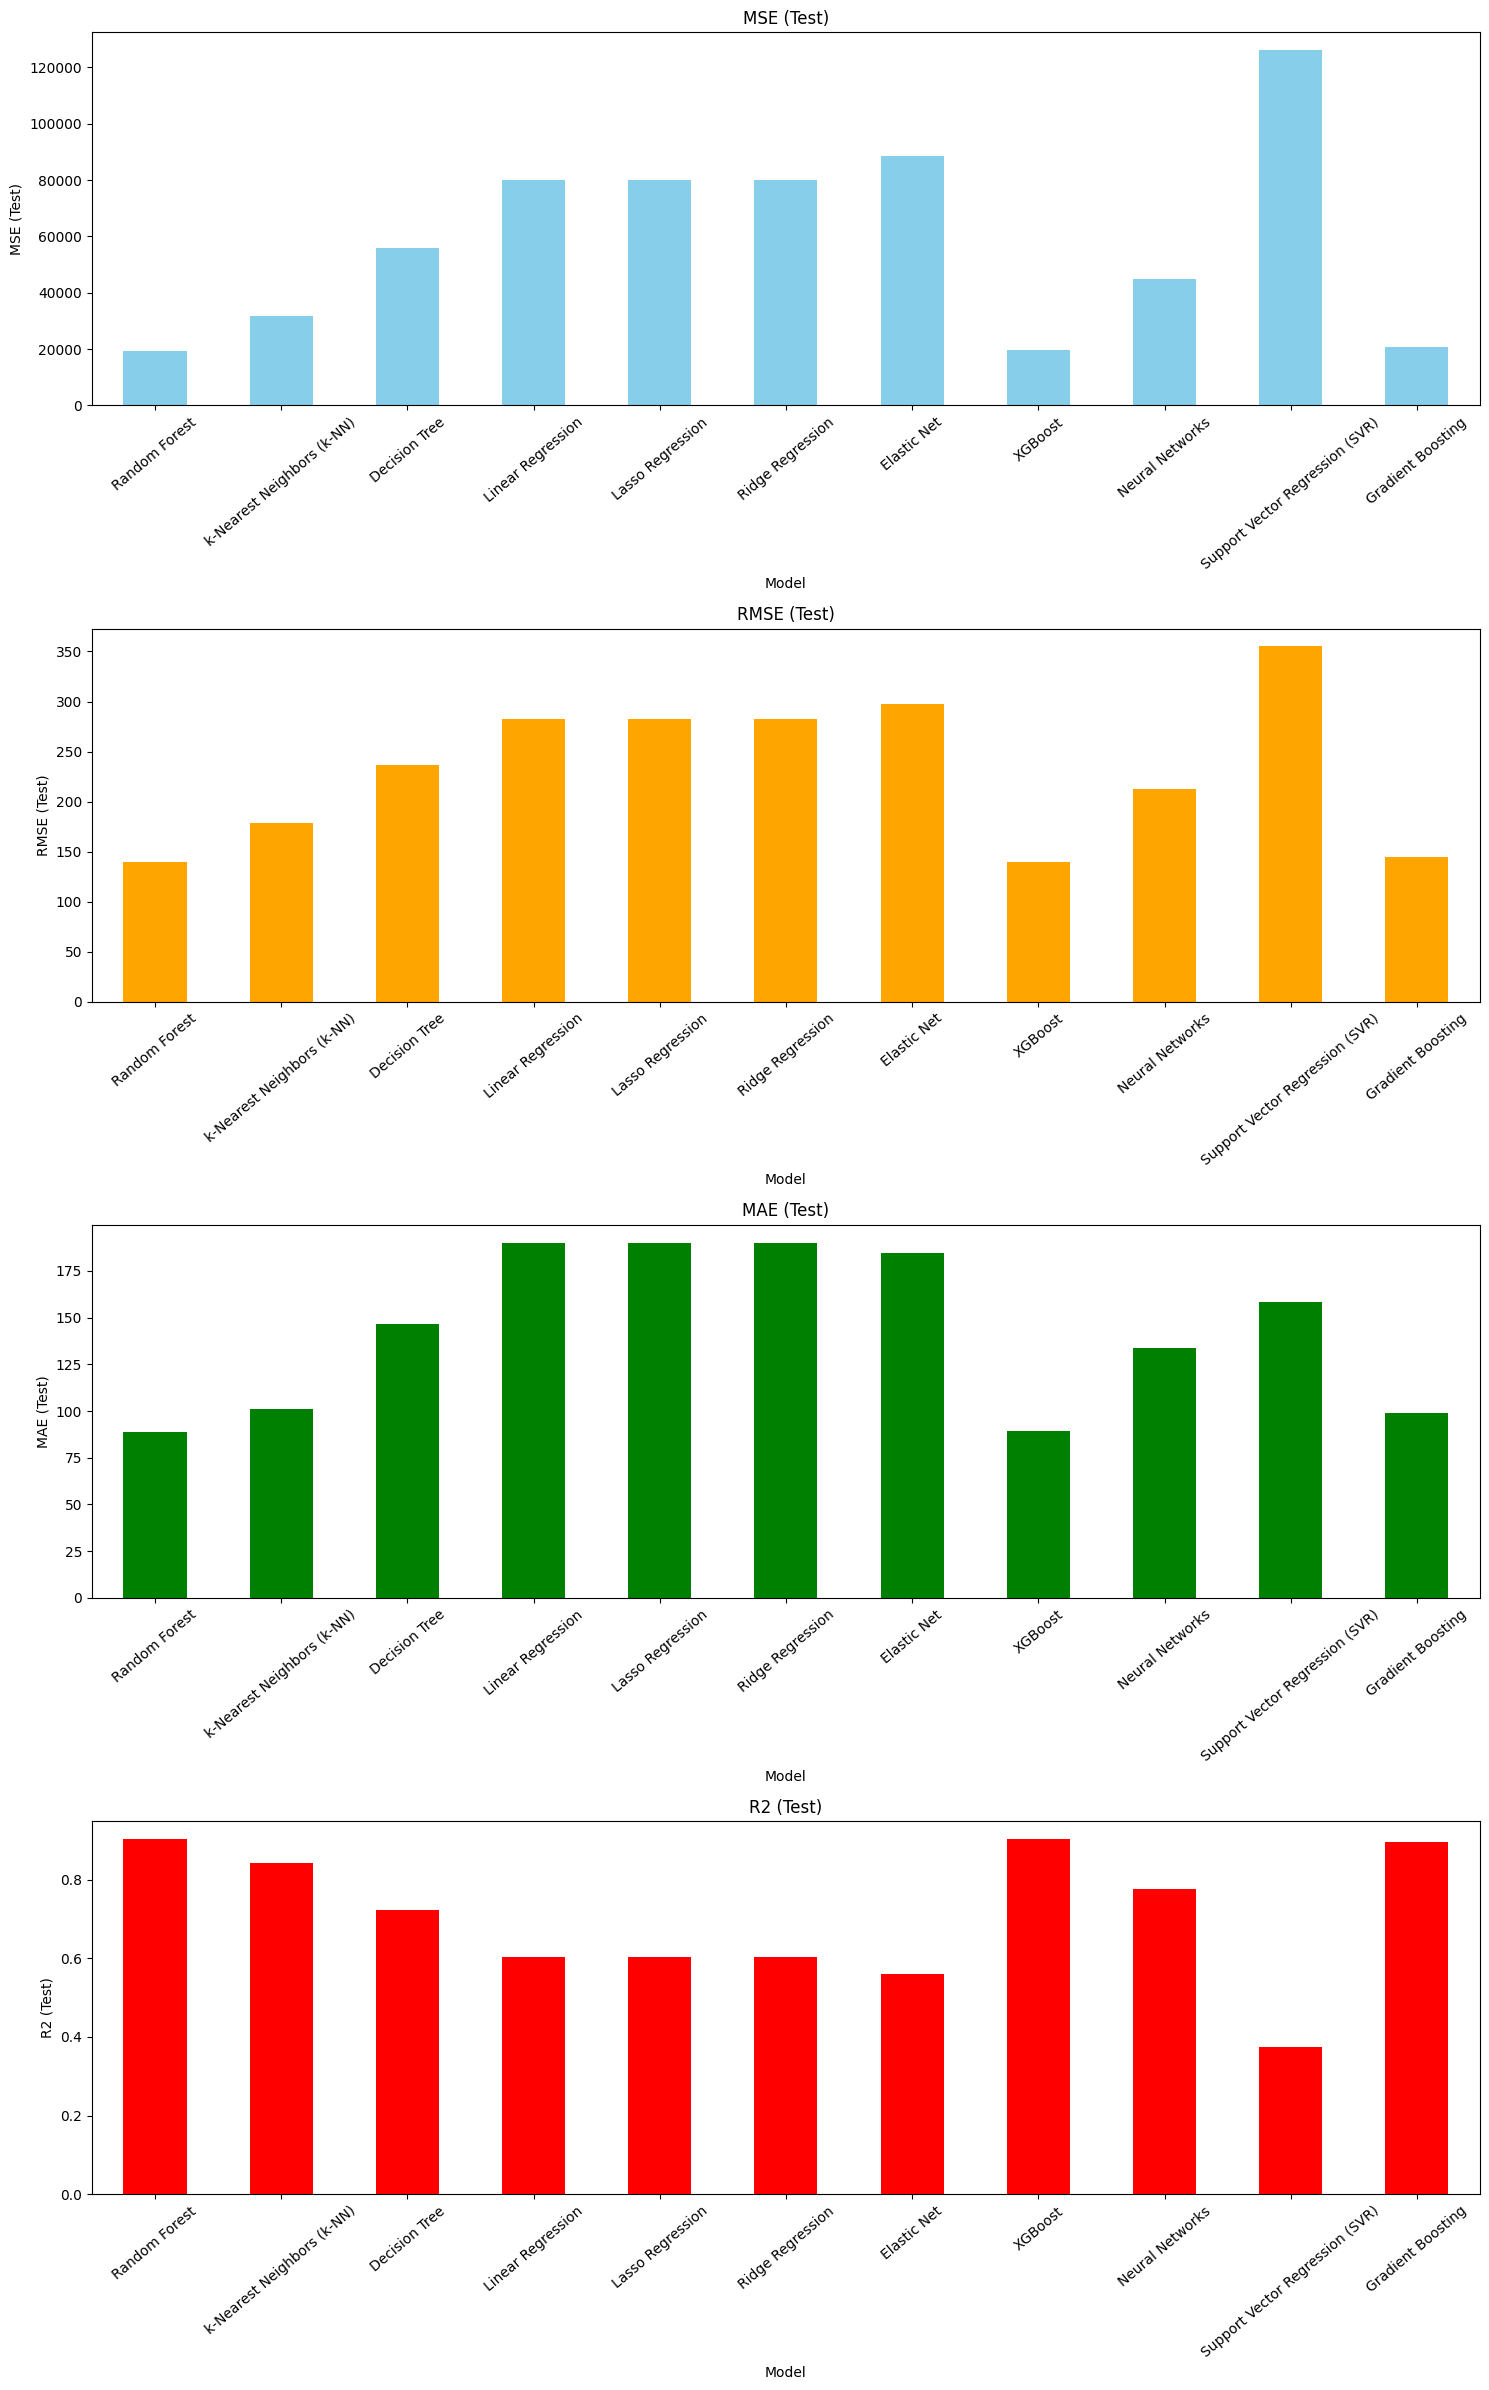

In [83]:
# Set the model names as the index
metrics_df_test.set_index('Model', inplace = True)

# Define the metrics
metrics_to_plot = ['MSE (Test)', 'RMSE (Test)', 'MAE (Test)', 'R2 (Test)']

# Create subplots for each metric
fig, axes = plt.subplots(nrows = len(metrics_to_plot_cv), ncols = 1, figsize = (15, 6 * len(metrics_to_plot_cv)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_to_plot):
    metrics_df_test[metric].plot(kind = 'bar', ax = axes[i], color = colors[i])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis = 'x', rotation = 40)

plt.tight_layout()
plt.show()

#### **Feature Scaling on Test Set**

In [84]:
# Initialize a StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
# Create an empty list to store dictionaries of metrics for the scaled test set
metrics_list_test_scaled = []

# Loop over models
for model_name, model in models:
    # Train the model on the scaled training set
    model.fit(X_train_scaled, y_train)

    # Make predictions on the scaled test set
    y_pred_test_scaled = model.predict(X_test_scaled)

    # Calculate performance metrics on the scaled test set
    mse_test_scaled = mean_squared_error(y_test, y_pred_test_scaled)
    rmse_test_scaled = mean_squared_error(y_test, y_pred_test_scaled, squared = False)
    mae_test_scaled = mean_absolute_error(y_test, y_pred_test_scaled)
    r2_test_scaled = r2_score(y_test, y_pred_test_scaled)

    # Append metrics to the list
    metrics_list_test_scaled.append({
        'Model': model_name,
        'MSE (Test Scaled)': mse_test_scaled,
        'RMSE (Test Scaled)': rmse_test_scaled,
        'MAE (Test Scaled)': mae_test_scaled,
        'R2 (Test Scaled)': r2_test_scaled
    })

# Create a dataframe from the list of metrics for the scaled test set
metrics_df_test_scaled = pd.DataFrame(metrics_list_test_scaled)
metrics_df_test_scaled

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e+05, tolerance: 1.368e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,MSE (Test Scaled),RMSE (Test Scaled),MAE (Test Scaled),R2 (Test Scaled)
0,Random Forest,6738.490333,82.088308,28.446417,0.966542
1,k-Nearest Neighbors (k-NN),32759.299465,180.995302,71.056531,0.837343
2,Decision Tree,55910.684052,236.454402,146.420291,0.722391
3,Linear Regression,35516.141655,188.457267,107.697172,0.823655
4,Lasso Regression,35425.732601,188.217248,107.703403,0.824103
5,Ridge Regression,35508.050753,188.435800,107.956752,0.823695
6,Elastic Net,35057.689430,187.236987,105.715681,0.825931
7,XGBoost,4242.170393,65.131946,35.740293,0.978937
8,Neural Networks,15497.813110,124.490213,46.160637,0.923050
9,Support Vector Regression (SVR),39492.683443,198.727661,90.958219,0.803910


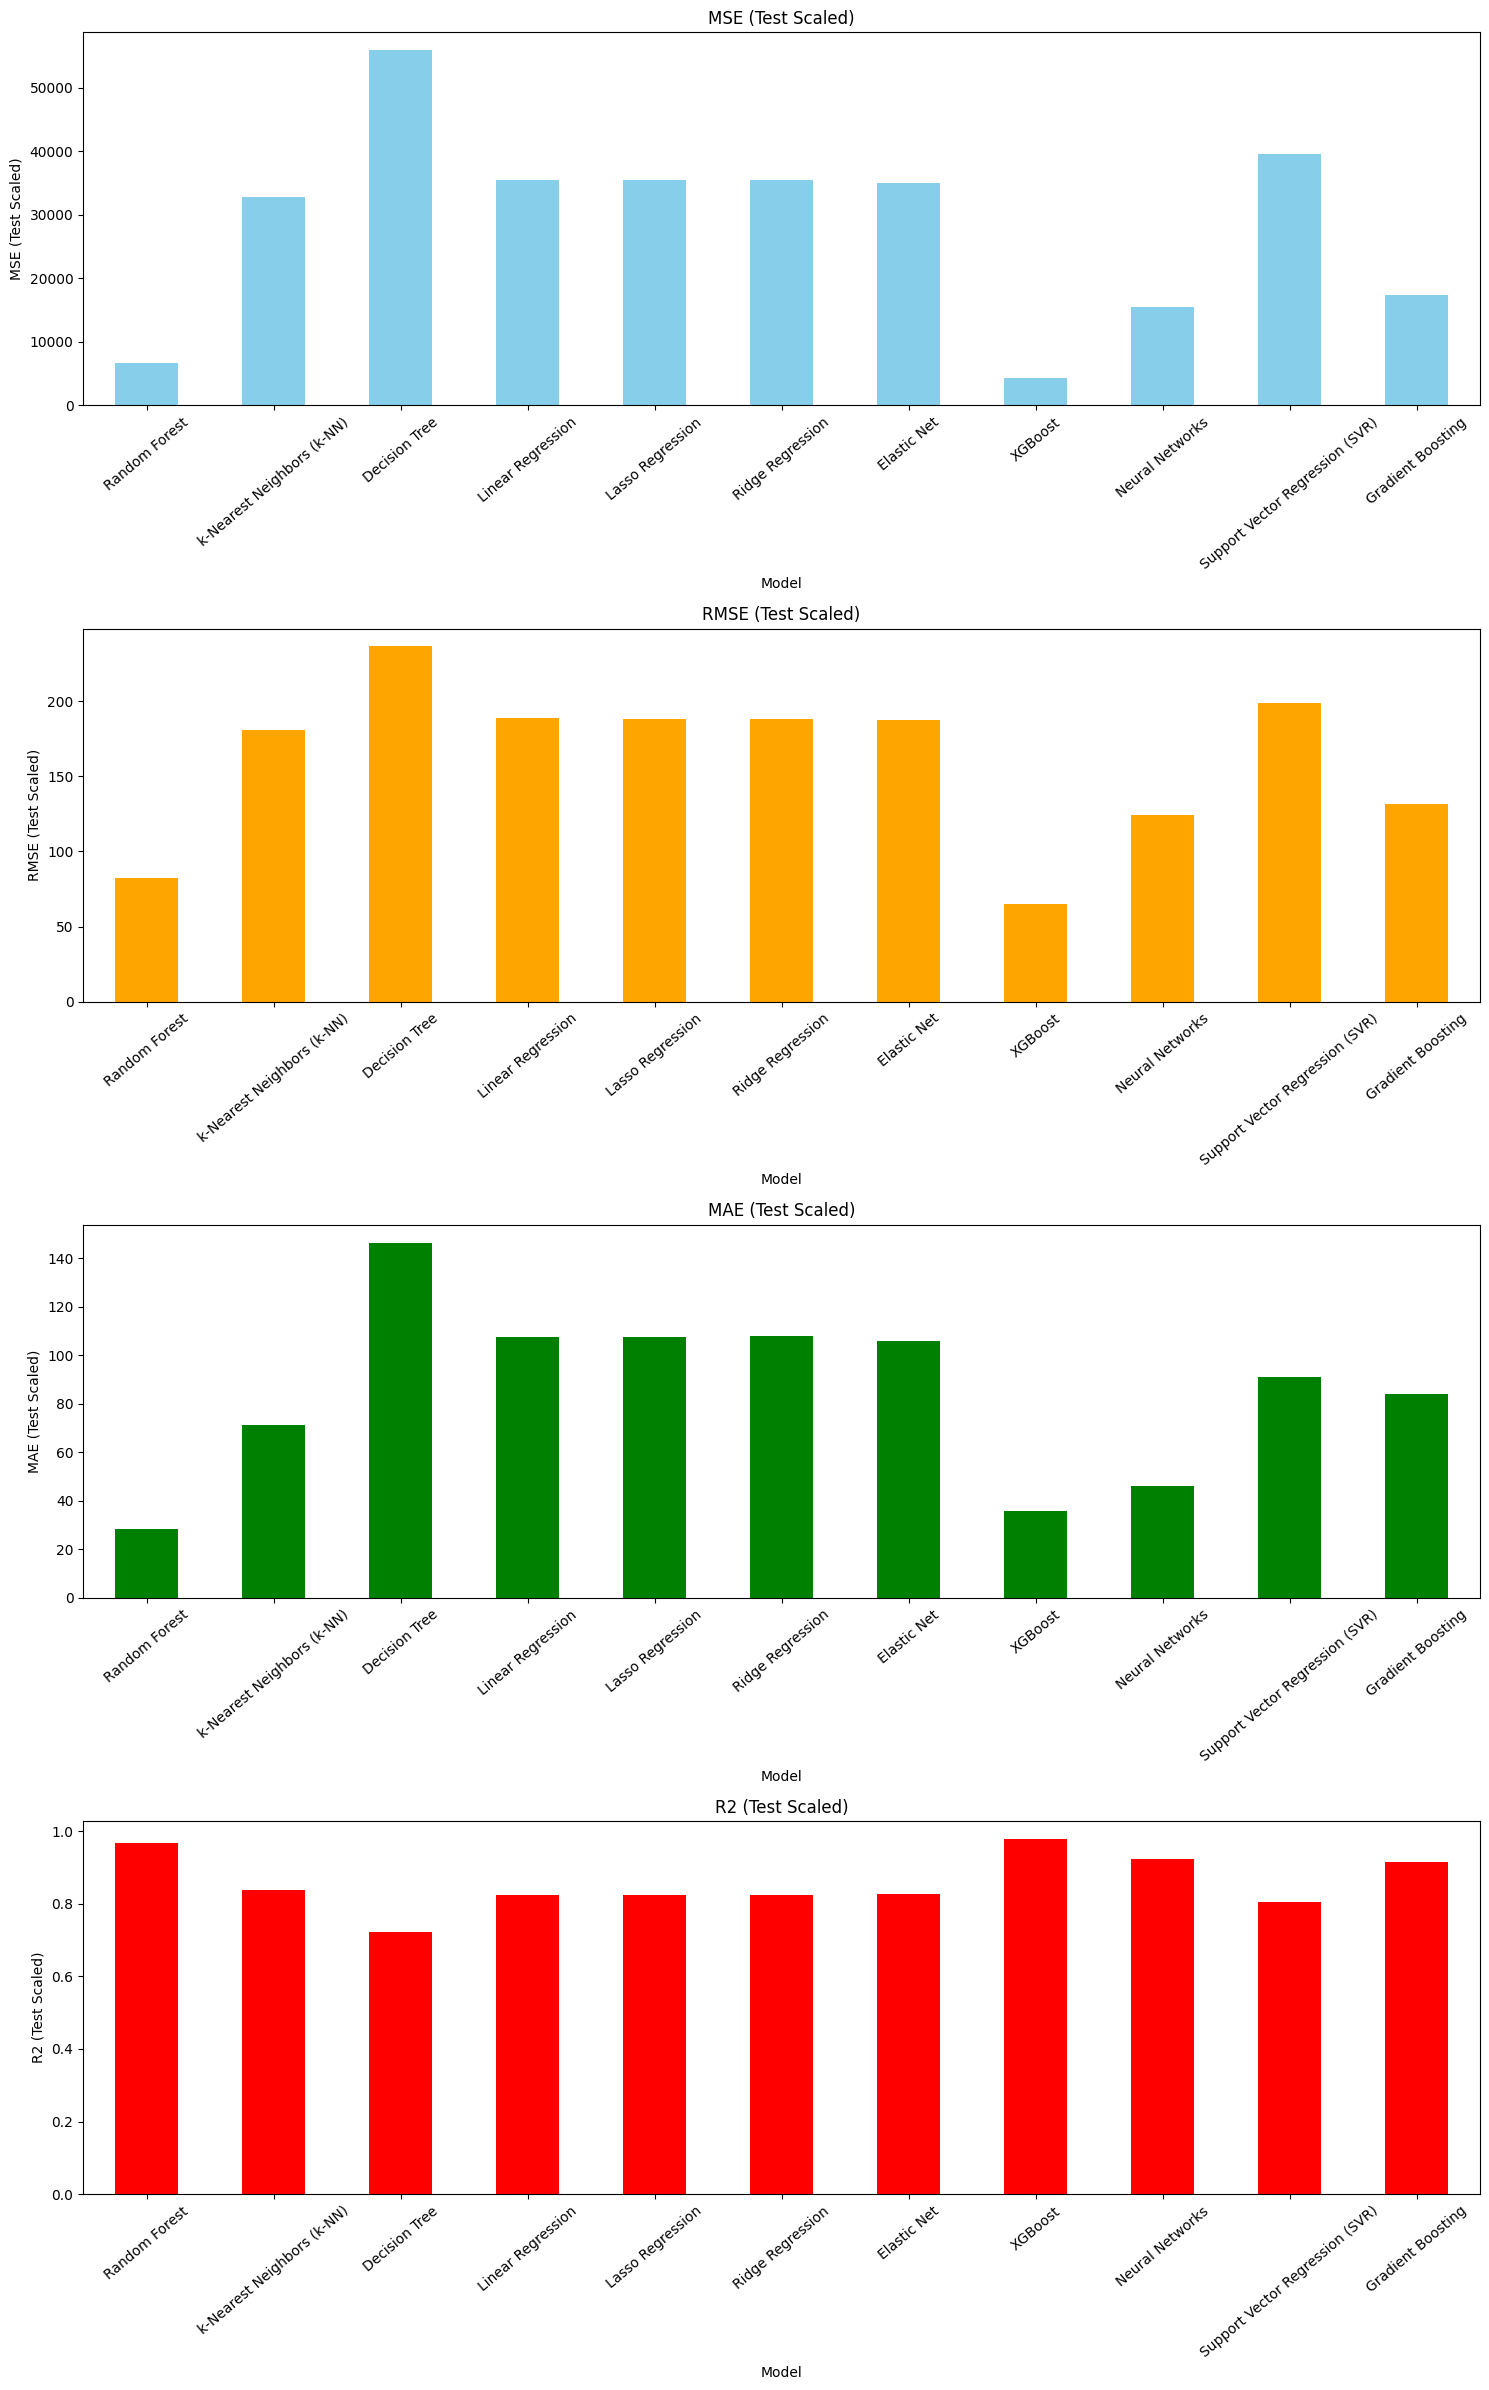

In [86]:
# Set the model names as the index
metrics_df_test_scaled.set_index('Model', inplace = True)

# Define the metrics
metrics_to_plot_test_scaled = ['MSE (Test Scaled)', 'RMSE (Test Scaled)', 'MAE (Test Scaled)', 'R2 (Test Scaled)']

# Create subplots for each metric
fig, axes = plt.subplots(nrows=len(metrics_to_plot_test_scaled), ncols = 1, figsize = (15, 6 * len(metrics_to_plot_test_scaled)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_to_plot_test_scaled):
    metrics_df_test_scaled[metric].plot(kind = 'bar', ax = axes[i], color = colors[i])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis = 'x', rotation = 40)

plt.tight_layout()
plt.show()